**Project context** <br>This notebook is part of the project "Bookmakerspy", a project that aims at predicting football games results in the context of the English Premier League (based on data from 2014 to 2018) and ultimately beat bookmakers' odds.<br>
The current notebook "bookmakerspy_modelisation" is the last in a series of 3 notebooks.<br>
**Notebook goal**<br>
This Notebook investigates the post-processed data (from the dataset 'df_results.csv' file) by applying various classification models:<br>
1- Selection of the most important features and model reduction<br>
2- Meta-parameters selection and use of comon classification models<br>
3- Comparison of model results applied on a dataset:<br>
        - without any modification<br>
        - with a feature selection<br> 
        - applying a dimension reduction<br>
   The best model is then compared with the best bookmaker predictions<br>
4- Betting strategy: proposing a betting strategy. Its gain curve is plotted in order to quantify the benefits of using machine learning model for sport bets

In [95]:
# Data Upload
import os
import pandas as pd
import numpy as np
import warnings
from joblib import dump, load

warnings.filterwarnings('ignore')

os.getcwd() 

df = pd.read_csv('df_results.csv', index_col = 0)
df = df.reset_index(drop=True).set_index('match_id')
df.head()

,season,date,away_team_id,away_team_name,home_team_id,home_team_name,home_team_rating,home_won_contest,home_possession_percentage,home_total_throws,home_blocked_scoring_att,home_total_scoring_att,home_total_tackle,home_aerial_won,home_aerial_lost,home_won_corners,home_shot_off_target,home_ontarget_scoring_att,home_total_offside,home_post_scoring_att,home_att_pen_goal,home_penalty_save,HF,HY,HR,home_pass,home_accurate_pass,home_total_pass,goalkeeper_home_player_rating,defender_home_player_rating,midfielder_home_player_rating,forward_home_player_rating,FTHG_mean,away_team_rating,away_won_contest,away_possession_percentage,away_total_throws,away_blocked_scoring_att,away_total_scoring_att,away_total_tackle,away_aerial_won,away_aerial_lost,away_won_corners,away_shot_off_target,away_ontarget_scoring_att,away_total_offside,away_post_scoring_att,away_att_pen_goal,away_penalty_save,AF,AY,AR,away_pass,away_accurate_pass,away_total_pass,goalkeeper_away_player_rating,defender_away_player_rating,midfielder_away_player_rating,forward_away_player_rating,FTAG_mean,FTR,FTHG,FTAG,B365H,B365D,B365A,LBH,LBD,LBA,PSH,PSD,PSA,WHH,WHD,WHA,VCH,VCD,VCA,PSCH,PSCD,PSCA,Diff_def_home_fwd_away,Diff_def_home_mid_away,Diff_mil_home_att_away,Diff_mil_home_mid_away,Diff_mil_home_def_away,Diff_fwd_home_mid_away,Diff_fwd_home_def_away,Diff_Goal
match_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
829595,2014_2015,2014-10-04,167,Manchester City,24,Aston Villa,6.519762,6.333333,38.133333,23.666667,2.333333,9.000000,14.000000,11.666667,15.000000,5.000000,4.666667,2.000000,2.000000,0.666667,0.000000,0.0,10.333333,2.000000,0.000000,0.756784,281.000000,370.333333,6.586667,6.551667,6.670889,6.925000,0.666667,7.160476,11.333333,56.733333,20.000000,3.333333,16.000000,25.666667,13.333333,14.666667,4.666667,6.333333,6.333333,0.666667,0.666667,0.000000,0.0,10.666667,3.666667,0.000000,0.850091,516.333333,605.666667,6.693333,7.280000,7.134333,7.948333,2.666667,A,0.0,2.0,7.50,4.50,1.5,6.50,4.33,1.5,8.05,4.57,1.48,7.00,3.75,1.53,8.00,4.50,1.5,8.70,5.00,1.42,-1.396667,-0.582667,-1.277444,-0.463444,-1.277444,-0.209333,-1.023333,-2.000000
829605,2014_2015,2014-10-04,162,Crystal Palace,214,Hull,6.802143,8.333333,41.300000,18.000000,2.000000,10.000000,24.333333,18.333333,19.000000,3.333333,3.666667,4.333333,0.333333,0.333333,0.333333,0.0,10.666667,1.333333,0.333333,0.783930,300.333333,381.333333,6.106667,7.147778,6.943000,7.081667,1.666667,6.832143,9.333333,28.100000,17.333333,2.666667,8.666667,24.000000,18.000000,19.666667,2.666667,2.000000,4.000000,1.333333,0.000000,0.333333,0.0,17.000000,2.333333,0.333333,0.634125,153.666667,241.333333,6.233333,6.933333,7.184833,7.183333,2.333333,H,2.0,0.0,2.10,3.50,3.8,2.05,3.40,4.0,2.12,3.44,3.89,2.10,3.10,3.80,2.10,3.40,3.9,2.18,3.45,3.67,-0.035556,-0.037056,-0.240333,-0.241833,-0.240333,-0.103167,-0.101667,-0.666667
829610,2014_2015,2014-10-04,184,Burnley,14,Leicester,6.957619,8.333333,37.066667,19.666667,3.000000,11.666667,18.666667,20.000000,19.333333,3.333333,5.000000,3.666667,2.333333,0.000000,0.666667,0.0,13.666667,1.666667,0.000000,0.759296,263.333333,346.666667,6.576667,7.047500,6.950000,7.531667,2.666667,6.458810,4.000000,45.700000,23.333333,4.333333,11.000000,13.000000,21.000000,22.000000,3.666667,4.666667,2.000000,1.333333,0.000000,0.000000,0.0,10.666667,2.000000,0.000000,0.759945,307.000000,403.666667,6.113333,6.861667,6.468500,6.205000,0.000000,D,2.0,2.0,1.80,3.75,5.0,1.80,3.60,5.0,1.79,3.72,5.16,1.80,3.25,5.00,1.80,3.70,5.0,1.72,4.05,5.20,0.842500,0.579000,0.745000,0.481500,0.745000,1.063167,1.326667,2.666667
829615,2014_2015,2014-10-04,175,West Bromwich Albion,26,Liverpool,6.888462,9.333333,59.066667,20.000000,6.000000,18.000000,18.333333,17.666667,10.666667,5.666667,7.333333,4.666667,2.333333,0.666667,0.000000,0.0,8.333333,1.666667,0.000000,0.863823,509.000000,586.666667,6.523333,7.121667,7.099333,6.960000,1.000000,6.659325,5.333333,41.566667,16.666667,3.666667,11.333333,19.000000,9.

In [2]:
os.listdir()

['.git',
 '.gitignore',
 '.ipynb_checkpoints',
 '1_bookmakerspy_data_collection.ipynb',
 '2_bookmakerspy_preprocessing_dataviz.ipynb',
 '3_bookmakerspy_modelisation.ipynb',
 'df_betting_strategy.csv',
 'df_results.csv',
 'df_stats_odds.csv',
 'README.md',
 'streamlit']

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1425 entries, 829595 to 1190547
Data columns (total 89 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   season                         1425 non-null   object 
 1   date                           1425 non-null   object 
 2   away_team_id                   1425 non-null   int64  
 3   away_team_name                 1425 non-null   object 
 4   home_team_id                   1425 non-null   int64  
 5   home_team_name                 1425 non-null   object 
 6   home_team_rating               1425 non-null   float64
 7   home_won_contest               1425 non-null   float64
 8   home_possession_percentage     1425 non-null   float64
 9   home_total_throws              1425 non-null   float64
 10  home_blocked_scoring_att       1425 non-null   float64
 11  home_total_scoring_att         1425 non-null   float64
 12  home_total_tackle              1425 non-

The dataset is splited (training and test samples): X_train, X_test, y_train, y_test 
We train the different models from the 2014-2015 season up to the 2016-2017 season, model evaluation is made on the 
last season, that is the 2017-2018 season. 
The idea is to consider that after having trained our model we are at the beginning of season 2017 and start applying our models and beting strategy putting ourselve in real conditions. This gives reasonnable proportions: 75% of the dataset for the trainings and 25% for the tests. A classic random spliting can also be considered.

In [4]:
from sklearn.model_selection import train_test_split
# Features
feats_list = [ # Features for the 'home' team
       'home_team_rating', 'home_won_contest', 'home_possession_percentage', 'home_total_throws', 'home_blocked_scoring_att', 
       'home_total_scoring_att', 'home_total_tackle', 'home_aerial_won', 'home_aerial_lost', 'home_accurate_pass', 
       'home_total_pass', 'home_won_corners', 'home_shot_off_target', 'home_ontarget_scoring_att','home_total_offside', 
       'home_post_scoring_att', 'home_att_pen_goal', 'home_penalty_save', 'HF', 'HY', 'HR', 'home_pass', 
       'goalkeeper_home_player_rating', 'defender_home_player_rating', 'midfielder_home_player_rating', 'forward_home_player_rating', 'FTHG_mean',       
               # Features for the 'away' team
       'away_team_rating', 'away_won_contest', 'away_possession_percentage', 'away_total_throws', 'away_blocked_scoring_att',
       'away_total_scoring_att', 'away_total_tackle', 'away_aerial_won', 'away_aerial_lost', 'away_accurate_pass', 
       'away_total_pass', 'away_won_corners', 'away_shot_off_target', 'away_ontarget_scoring_att', 'away_total_offside', 
       'away_post_scoring_att', 'away_att_pen_goal', 'away_penalty_save', 'AF', 'AY', 'AR', 'away_pass',
       'goalkeeper_away_player_rating', 'defender_away_player_rating', 'midfielder_away_player_rating', 'forward_away_player_rating', 'FTAG_mean',
        # Bookmakers odds
        # 'B365H', 'B365D', 'B365A', 'LBH', 'LBD', 'LBA', 'PSH', 'PSD',
        # 'PSA', 'WHH', 'WHD', 'WHA', 'VCH', 'VCD', 'VCA', 'PSCH', 'PSCD', 'PSCA'
    
        # Team Comparison
       'Diff_def_home_fwd_away', 'Diff_def_home_mid_away', 'Diff_mil_home_att_away', 'Diff_mil_home_mid_away',
       'Diff_mil_home_def_away', 'Diff_fwd_home_mid_away', 'Diff_fwd_home_def_away', 'Diff_Goal']
       
# Target
target_list = 'FTR'

# Split by considering last season as target
#Train = df[df['season']!='2017_2018']
#Test  = df[df['season']=='2017_2018']
#X_train = Train[feats_list]
#X_test  = Test[feats_list]
#y_train = Train[target_list].reset_index(drop=True)
#y_test  = Test[target_list].reset_index(drop=True)


# Split by using shuffle parameter of train_test_split function
data = df[feats_list]
target = df[target_list]

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.25, shuffle = False, random_state=789)

In [5]:
# Draw results are filtered, they are not predicted by the bookmakers. This filter would focus 
#to_drop =y_train[y_train=='D' ].index
#X_train = X_train.drop(to_drop,axis=0)

In [6]:
# Dataframe display
pd.set_option('display.max_columns', None)
df.head()

,season,date,away_team_id,away_team_name,home_team_id,home_team_name,home_team_rating,home_won_contest,home_possession_percentage,home_total_throws,home_blocked_scoring_att,home_total_scoring_att,home_total_tackle,home_aerial_won,home_aerial_lost,home_won_corners,home_shot_off_target,home_ontarget_scoring_att,home_total_offside,home_post_scoring_att,home_att_pen_goal,home_penalty_save,HF,HY,HR,home_pass,home_accurate_pass,home_total_pass,goalkeeper_home_player_rating,defender_home_player_rating,midfielder_home_player_rating,forward_home_player_rating,FTHG_mean,away_team_rating,away_won_contest,away_possession_percentage,away_total_throws,away_blocked_scoring_att,away_total_scoring_att,away_total_tackle,away_aerial_won,away_aerial_lost,away_won_corners,away_shot_off_target,away_ontarget_scoring_att,away_total_offside,away_post_scoring_att,away_att_pen_goal,away_penalty_save,AF,AY,AR,away_pass,away_accurate_pass,away_total_pass,goalkeeper_away_player_rating,defender_away_player_rating,midfielder_away_player_rating,forward_away_player_rating,FTAG_mean,FTR,FTHG,FTAG,B365H,B365D,B365A,LBH,LBD,LBA,PSH,PSD,PSA,WHH,WHD,WHA,VCH,VCD,VCA,PSCH,PSCD,PSCA,Diff_def_home_fwd_away,Diff_def_home_mid_away,Diff_mil_home_att_away,Diff_mil_home_mid_away,Diff_mil_home_def_away,Diff_fwd_home_mid_away,Diff_fwd_home_def_away,Diff_Goal
match_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
829595,2014_2015,2014-10-04,167,Manchester City,24,Aston Villa,6.519762,6.333333,38.133333,23.666667,2.333333,9.000000,14.000000,11.666667,15.000000,5.000000,4.666667,2.000000,2.000000,0.666667,0.000000,0.0,10.333333,2.000000,0.000000,0.756784,281.000000,370.333333,6.586667,6.551667,6.670889,6.925000,0.666667,7.160476,11.333333,56.733333,20.000000,3.333333,16.000000,25.666667,13.333333,14.666667,4.666667,6.333333,6.333333,0.666667,0.666667,0.000000,0.0,10.666667,3.666667,0.000000,0.850091,516.333333,605.666667,6.693333,7.280000,7.134333,7.948333,2.666667,A,0.0,2.0,7.50,4.50,1.5,6.50,4.33,1.5,8.05,4.57,1.48,7.00,3.75,1.53,8.00,4.50,1.5,8.70,5.00,1.42,-1.396667,-0.582667,-1.277444,-0.463444,-1.277444,-0.209333,-1.023333,-2.000000
829605,2014_2015,2014-10-04,162,Crystal Palace,214,Hull,6.802143,8.333333,41.300000,18.000000,2.000000,10.000000,24.333333,18.333333,19.000000,3.333333,3.666667,4.333333,0.333333,0.333333,0.333333,0.0,10.666667,1.333333,0.333333,0.783930,300.333333,381.333333,6.106667,7.147778,6.943000,7.081667,1.666667,6.832143,9.333333,28.100000,17.333333,2.666667,8.666667,24.000000,18.000000,19.666667,2.666667,2.000000,4.000000,1.333333,0.000000,0.333333,0.0,17.000000,2.333333,0.333333,0.634125,153.666667,241.333333,6.233333,6.933333,7.184833,7.183333,2.333333,H,2.0,0.0,2.10,3.50,3.8,2.05,3.40,4.0,2.12,3.44,3.89,2.10,3.10,3.80,2.10,3.40,3.9,2.18,3.45,3.67,-0.035556,-0.037056,-0.240333,-0.241833,-0.240333,-0.103167,-0.101667,-0.666667
829610,2014_2015,2014-10-04,184,Burnley,14,Leicester,6.957619,8.333333,37.066667,19.666667,3.000000,11.666667,18.666667,20.000000,19.333333,3.333333,5.000000,3.666667,2.333333,0.000000,0.666667,0.0,13.666667,1.666667,0.000000,0.759296,263.333333,346.666667,6.576667,7.047500,6.950000,7.531667,2.666667,6.458810,4.000000,45.700000,23.333333,4.333333,11.000000,13.000000,21.000000,22.000000,3.666667,4.666667,2.000000,1.333333,0.000000,0.000000,0.0,10.666667,2.000000,0.000000,0.759945,307.000000,403.666667,6.113333,6.861667,6.468500,6.205000,0.000000,D,2.0,2.0,1.80,3.75,5.0,1.80,3.60,5.0,1.79,3.72,5.16,1.80,3.25,5.00,1.80,3.70,5.0,1.72,4.05,5.20,0.842500,0.579000,0.745000,0.481500,0.745000,1.063167,1.326667,2.666667
829615,2014_2015,2014-10-04,175,West Bromwich Albion,26,Liverpool,6.888462,9.333333,59.066667,20.000000,6.000000,18.000000,18.333333,17.666667,10.666667,5.666667,7.333333,4.666667,2.333333,0.666667,0.000000,0.0,8.333333,1.666667,0.000000,0.863823,509.000000,586.666667,6.523333,7.121667,7.099333,6.960000,1.000000,6.659325,5.333333,41.566667,16.666667,3.666667,11.333333,19.000000,9.

In [7]:
#Standardisation
from sklearn.preprocessing import StandardScaler     

scaler = StandardScaler().fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), index = X_train.index, columns = X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), index = X_test.index, columns = X_test.columns)

In [8]:
print('Number of features :', len(X_train.columns))

Number of features : 62


# 1 Dimension reduction of the dataset

## 1.1 Wrapper RFECV

In [9]:
# The function RFECV is considered as it allows the use of various folds. We have a classification problem
# and a tree classifier is used with the RFECV.

from sklearn.model_selection import KFold
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=123)
crossval = KFold(n_splits = 3, random_state = 2, shuffle = True)
rfecv = RFECV(estimator=dt, cv = crossval, step=1)
rfecv.fit(X_train, y_train)

RFECV(cv=KFold(n_splits=3, random_state=2, shuffle=True),
      estimator=DecisionTreeClassifier(random_state=123))

In [10]:
print('Optimal number of features :', rfecv.n_features_)

Optimal number of features : 45


In [11]:
print('Deleted features :', X_train.columns[~rfecv.support_])
list_rfecv = X_train.columns[~rfecv.support_]

Deleted features : Index(['home_blocked_scoring_att', 'home_aerial_won', 'home_total_offside',
       'home_post_scoring_att', 'home_att_pen_goal', 'home_penalty_save', 'HR',
       'FTHG_mean', 'away_won_corners', 'away_ontarget_scoring_att',
       'away_total_offside', 'away_att_pen_goal', 'away_penalty_save', 'AR',
       'Diff_mil_home_mid_away', 'Diff_mil_home_def_away',
       'Diff_fwd_home_mid_away'],
      dtype='object')


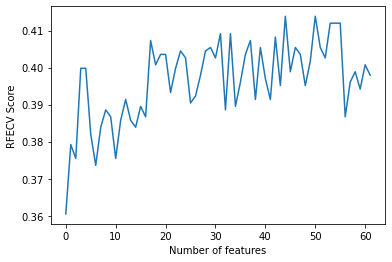

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.xlabel("Number of features")
plt.ylabel("RFECV Score")
plt.plot(rfecv.grid_scores_);
plt.show()
# The integer n_features represents the number of features selected by the algorithm.

# grid_scores_ gives the mean score by cross-validation for the various iterations. It allows to plot the RFECV score as a 
# fucntion of the feature number

## 1.2 Logistic Regression with Elasticnet

In [13]:
from sklearn.feature_selection import SelectFromModel
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, cross_val_score

# Logistic regression via easticnet for the feature selection
#parametres = {'C':[0.1,1,3],'l1_ratio': [0.1, 0.25, 0.8, 0.99]}
#clf = linear_model.LogisticRegression(penalty = 'elasticnet', solver = 'saga', max_iter = 2000)

parametres = {'C':[0.1],'l1_ratio': [0.99]}
clf = linear_model.LogisticRegression(penalty = 'elasticnet', solver = 'saga', max_iter = 2000)
# High value of max_iter is necessary to ensure convergence
grid_clf = GridSearchCV(estimator=clf, param_grid=parametres)
grille = grid_clf.fit(X_train,y_train)
print('Best parameters:',grid_clf.best_params_) 

Best parameters: {'C': 0.1, 'l1_ratio': 0.99}


In [14]:
# Remark: Minimum value for C and maximum for l1_ratio are selected. No out of bounds values could be found

In [16]:
optimal_clf = grid_clf.best_estimator_
elast_coef = optimal_clf.coef_
elast = np.abs(elast_coef)
keep = np.where(~((elast[0,:]==0)&(elast[1,:]==0)&(elast[2,:]==0)))
coeff_keep_0 = elast[0,keep[0]]
index_keep_0 = X_train.columns.values[keep[0]]
coeff_sort_0 = coeff_keep_0[coeff_keep_0.argsort()]
index_sort_0 = index_keep_0[coeff_keep_0.argsort()]

coeff_keep_1 = elast[1,keep[0]]
index_keep_1 = X_train.columns.values[keep[0]]
coeff_sort_1 = coeff_keep_1[coeff_keep_1.argsort()]
index_sort_1 = index_keep_1[coeff_keep_1.argsort()]

coeff_keep_2 = elast[2,keep[0]]
index_keep_2 = X_train.columns.values[keep[0]]
coeff_sort_2 = coeff_keep_2[coeff_keep_2.argsort()]
index_sort_2 = index_keep_2[coeff_keep_2.argsort()]


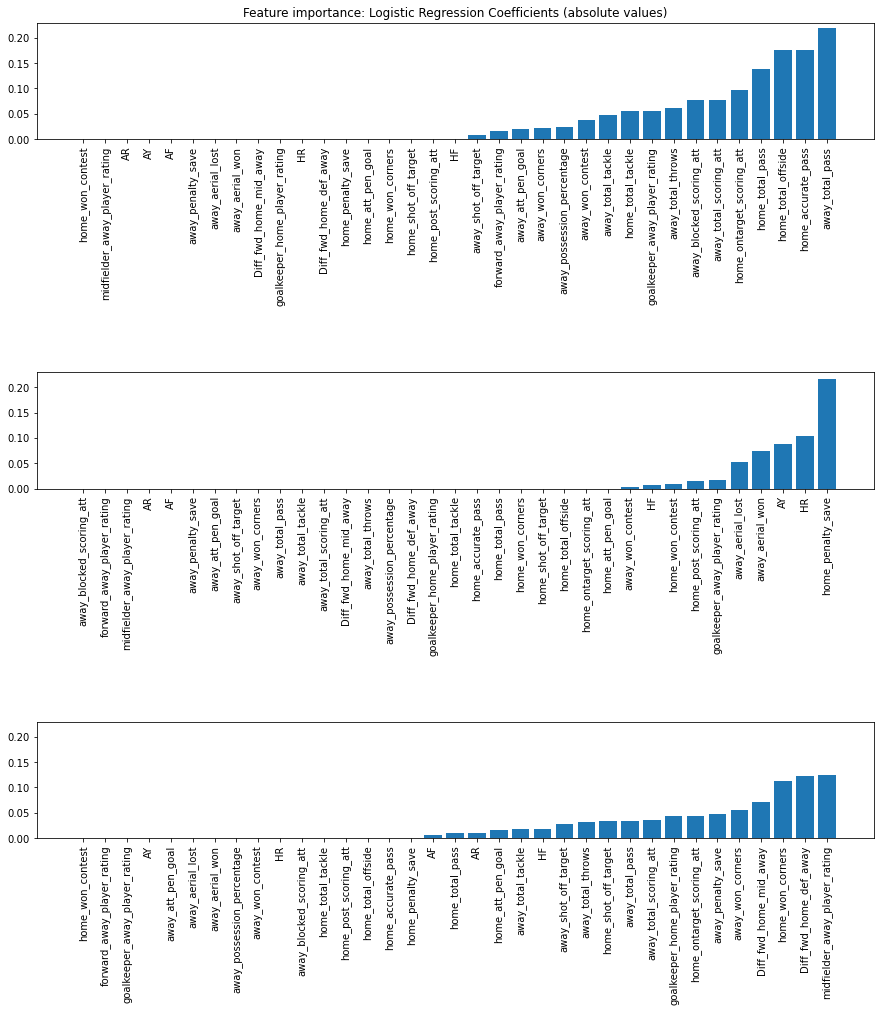

In [17]:
ticks = np.arange(0, len(index_sort_0))
fig, [ax1, ax2, ax3] = plt.subplots(3,1,figsize=(15,15), sharex = False, sharey = True)
ax1.bar(ticks, coeff_sort_0)
ax1.set_xticks(ticks)
ax1.set_xticklabels(index_sort_0, rotation='vertical')

ax2.bar(ticks, coeff_sort_1)
ax2.set_xticks(ticks)
ax2.set_xticklabels(index_sort_1, rotation='vertical')

ax3.bar(ticks, coeff_sort_2)
ax3.set_xticks(ticks)
ax3.set_xticklabels(index_sort_2, rotation='vertical')

ax1.set_title("Feature importance: Logistic Regression Coefficients (absolute values)")
plt.subplots_adjust(hspace= 2)
plt.show()

In [ ]:
# The feature importance is plotted for the 3 regressions performed (for the 3 possible classes of the target)
# Features to be deleted have a zero coefficient
# optimal_clf = grid_clf.best_estimator_
# elast_coef = optimal_clf.coef_

#ticks = np.arange(0, len(elast_coef[0,:]))
#fig, [ax1, ax2, ax3] = plt.subplots(3,1,figsize=(15,15), sharex = False, sharey = True)
#ax1.bar(ticks, np.abs(elast_coef[0,elast_coef[0,:].argsort()]))
#ax1.set_xticks(ticks)
#ax1.set_xticklabels(X_train.columns.values[elast_coef[0,:].argsort()], rotation='vertical')

#ax2.bar(ticks, np.abs(elast_coef[1,elast_coef[1,:].argsort()]))
#ax2.set_xticks(ticks)
#ax2.set_xticklabels(X_train.columns.values[elast_coef[1,:].argsort()], rotation='vertical')

#ax3.bar(ticks, np.abs(elast_coef[2,elast_coef[2,:].argsort()]))
#ax3.set_xticks(ticks)
#ax3.set_xticklabels(X_train.columns.values[elast_coef[2,:].argsort()], rotation='vertical')
#ax1.set_title("Feature importance: Logistic Regression Coefficients (absolute values)")
#plt.subplots_adjust(hspace= 2)
#plt.show()

## 1.3 PCA

In [18]:
from sklearn.decomposition import PCA
# First, the optimal number of vectors to represent the dataset is searched
data = df[feats_list]
pca = PCA(n_components = 6)
pca.fit(data)

PCA(n_components=6)

Text(0.5, 0, 'Number of components')

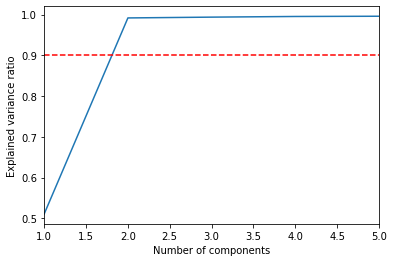

In [19]:
plt.figure()
plt.xlim(1,5)
x = np.arange(1,6)
#plt.plot(np.array(range(0,6)),pca.explained_variance_ratio_);
plt.plot(x,pca.explained_variance_ratio_.cumsum()[:len(x)]);
plt.axhline(y = 0.9, color ='r', linestyle = '--')
plt.ylabel("Explained variance ratio")
plt.xlabel("Number of components")

In [77]:
pca = PCA(n_components = 0.9)
pca.fit(data)
print("Number of components:", pca.n_components_)

Number of components: 2


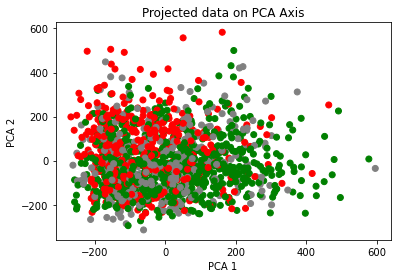

Explained standard deviation 0.99


In [21]:
# As only 2 components are enough, a 2D vizualization of the data in the reduced space is possible. 

# PCA 2D plot colored by labels:
pca_2D = PCA(n_components = 2)
data_2D_pca = pca_2D.fit_transform(data)
target = df[target_list].values

fig = plt.figure()
ax = fig.add_subplot(111)
colors = {'A':'red', 'D':'gray', 'H':'green'}
ax.scatter(data_2D_pca[:, 0], data_2D_pca[:, 1], c = df[target_list].map(colors))

ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_title("Projected data on PCA Axis")

plt.show();
print("Explained standard deviation", round(pca.explained_variance_ratio_.sum(),2))


In [22]:
# It is difficult to separate the different labels in distinct zones using a PCA reduction 

## 1.4 LDA

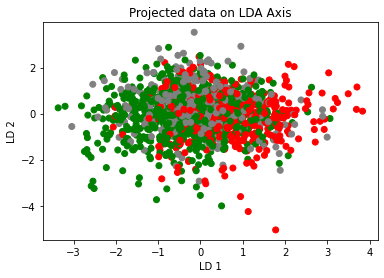

In [23]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA()
target = df[target_list].values
data_2D_lda = lda.fit_transform(data, target)

plt.show()
fig = plt.figure()
ax = fig.add_subplot(111)
colors = {'A':'red', 'D':'gray', 'H':'green'}
ax.scatter(data_2D_lda[:, 0], data_2D_lda[:, 1], c = df[target_list].map(colors))
ax.set_xlabel('LD 1')
ax.set_ylabel('LD 2')
 
ax.set_title("Projected data on LDA Axis")
plt.show();


In [24]:
# It is difficult to separate the different labels in distinct zones using a LDA reduction 

## 1.5 Manifold - tNSE

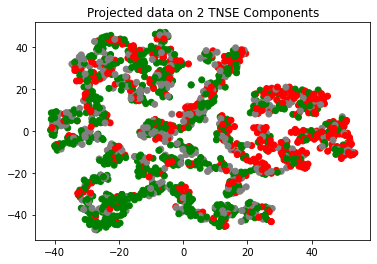

In [25]:
from sklearn.manifold import Isomap, TSNE

tsne = TSNE(n_components=2, method = 'barnes_hut')
dataTSNE = tsne.fit_transform(data)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(dataTSNE[:, 0], dataTSNE[:, 1],  c = df[target_list].map(colors))
ax.set_title("Projected data on 2 TNSE Components")
plt.show();

## 1.6 Manifold - IsoMap

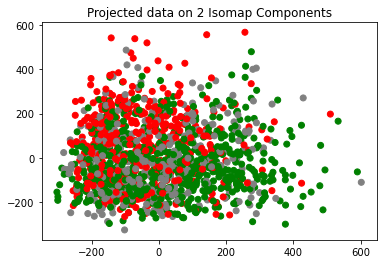

In [26]:
isomap = Isomap(n_neighbors=50, n_components=2)
dataISO = isomap.fit_transform(data)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(dataISO[:, 0], dataISO[:, 1],  c =df[target_list].map(colors))
ax.set_title("Projected data on 2 Isomap Components")
plt.show();

In [27]:
# There is no particular method that seems to separate the labels (this does not mean that there are not efficients).

In the rest, 3 different datasets are considered:
- A non reduced dataset: the suffix "_NR" will be used to specify variables associated with this dataset.

- A dataset with selected features via the logistic regression deleting features with zero coefficient of importance. A suffix "_FS" will be used to specify variables associated with this dataset.

- A reduced dimension dataset: the suffix "_R" will be used to specify variables associated with this dataset.

In [60]:
# Dataset _NR
X_train_NR = X_train
X_test_NR = X_test

In [29]:
# Columns in common:
del_col_0 = set(X_train.columns.values[np.where(optimal_clf.coef_[0,:]==0)])
del_col_1 = set(X_train.columns.values[np.where(optimal_clf.coef_[1,:]==0)])
del_col_2 = set(X_train.columns.values[np.where(optimal_clf.coef_[2,:]==0)])

print('Number of columns to be deleted:',len(del_col_0.intersection(del_col_1, del_col_2)),'\n')
print('Variables to be deleted:')
print(del_col_0.intersection(del_col_1, del_col_2))

Number of columns to be deleted: 27 

Variables to be deleted:
{'home_team_rating', 'away_total_offside', 'away_post_scoring_att', 'home_total_throws', 'home_blocked_scoring_att', 'home_total_scoring_att', 'forward_home_player_rating', 'away_ontarget_scoring_att', 'FTAG_mean', 'Diff_Goal', 'Diff_def_home_fwd_away', 'HY', 'defender_home_player_rating', 'away_team_rating', 'defender_away_player_rating', 'Diff_mil_home_mid_away', 'away_accurate_pass', 'Diff_mil_home_def_away', 'away_pass', 'Diff_def_home_mid_away', 'home_possession_percentage', 'home_aerial_won', 'midfielder_home_player_rating', 'FTHG_mean', 'home_pass', 'Diff_mil_home_att_away', 'home_aerial_lost'}


In [54]:
to_drop = list(del_col_0.intersection(del_col_1, del_col_2))
X_train_FS = X_train.drop(to_drop, axis=1)
X_test_FS  = X_test.drop(to_drop, axis=1)

In [80]:
# Dataset _R
X_train_R = pca.fit_transform(X_train)
X_test_R = pca.transform(X_test)

In [81]:
df_X_test_R = pd.DataFrame(X_test_R)
df_X_test_R.to_csv('X_test_R.csv')
y_test.to_csv('y_test.csv')

# 2 - Classification models

In this section the most comon algorithm are tested for each dataset previously created.
For each case, a confusion matrix and a classification report is produced in order to compare the models and measure the benefits of using a reduced dataset or a dataset with selected features.

## 2.1 Logistic regression

In [ ]:
from sklearn.metrics import classification_report 
parametres = {'C':[0.05,0.1,1,3],'l1_ratio': [0.01, 0.1, 0.2, 0.5, 0.99]}

clf_NR = linear_model.LogisticRegression(penalty = 'elasticnet', solver = 'saga',max_iter = 2000)
clf_FS = linear_model.LogisticRegression(penalty = 'elasticnet', solver = 'saga',max_iter = 2000)
clf_R  = linear_model.LogisticRegression(penalty = 'elasticnet', solver = 'saga',max_iter = 2000)

grid_clf_NR = GridSearchCV(estimator=clf_NR, param_grid=parametres)
grid_clf_FS = GridSearchCV(estimator=clf_FS, param_grid=parametres)
grid_clf_R = GridSearchCV(estimator=clf_R, param_grid=parametres)

grid_clf_NR.fit(X_train_NR,y_train)
grid_clf_FS.fit(X_train_FS,y_train)
grid_clf_R.fit(X_train_R,y_train)

print('Best parameters, non reduced dataset:',grid_clf_NR.best_params_) 
print('Best parameters, dataset with feature reduction:',grid_clf_FS.best_params_) 
print('Best parameters, reduced dataset:',grid_clf_R.best_params_) 
# Remark: Minimum value for C and maximum for l1_ratio are selected. No out of bounds values could be found

In [ ]:
y_pred_cfl_NR = grid_clf_NR.predict(X_test_NR)
y_pred_cfl_FS = grid_clf_FS.predict(X_test_FS)
y_pred_cfl_R  = grid_clf_R.predict(X_test_R)

In [ ]:
# Classification report / Results for the reduced dataset are better / Draws are not predicted
print('Non reduced Dataset (NR):')
print(classification_report(y_test, pd.DataFrame(y_pred_cfl_NR)))
print('Dataset with selected features (FS):')
print(classification_report(y_test, pd.DataFrame(y_pred_cfl_FS)))
print('Reduced Dataset (R):')
print(classification_report(y_test, pd.DataFrame(y_pred_cfl_R)))

In [ ]:
# Confusion matrix
print('Non reduced Dataset (NR):')
pd.crosstab(y_test, y_pred_cfl_NR, rownames=['Real'], colnames=['Predicted'])

In [ ]:
print('Dataset with selected features (FS):')
pd.crosstab(y_test,y_pred_cfl_FS, rownames=['Real'], colnames=['Predicted'])

In [ ]:
print('Reduced Dataset (R):')
pd.crosstab(y_test, y_pred_cfl_R, rownames=['Real'], colnames=['Predicted'])

In [ ]:
# Score comparison between the test and train dataset (overfitting check)
print('Score on (Test, Train) datasets, Non reduced Dataset (NR): (',grid_clf_NR.score(X_train_NR, y_train),' ,', grid_clf_NR.score(X_test, y_test) ,' )')
print('Score on (Test, Train) datasets, Selected Features (FS): (', grid_clf_FS.score(X_train_FS, y_train),' ,', grid_clf_FS.score(X_test_FS, y_test) ,' )')
print('Score on (Test, Train) datasets, Reduced Dataset (R): (',grid_clf_R.score(X_train_R, y_train),' ,' ,grid_clf_R.score(X_test_R, y_test) ,' )')

In [ ]:
# creating a dataframe that contains the results to be able to display a chart that 
# will help comparing results for all models further down in the notebook
f1_models = pd.DataFrame(columns= ['Model','Result','F1score'])

In [ ]:
# adding the f1 score results to the dataframe
tab_models = [['Log. regression NR', y_pred_cfl_NR],['Log. regression FS',y_pred_cfl_FS],['Log. regression R',y_pred_cfl_R]]
for model in tab_models:
    f1_models = f1_models.append({'Model': model[0], 'Result': 'A', 'F1score': classification_report(y_test, pd.DataFrame(model[1]), output_dict=True)['A']['f1-score']}, ignore_index=True)
    f1_models = f1_models.append({'Model': model[0], 'Result': 'H', 'F1score': classification_report(y_test, pd.DataFrame(model[1]), output_dict=True)['H']['f1-score']}, ignore_index=True)
    f1_models = f1_models.append({'Model': model[0], 'Result': 'D', 'F1score': classification_report(y_test, pd.DataFrame(model[1]), output_dict=True)['D']['f1-score']}, ignore_index=True)

## 2.2 K Nearest Neigborhood

In [ ]:
from sklearn import neighbors
# Best parameters selection
parametres = {'n_neighbors': [10, 20, 30, 40, 50], 'metric': ['manhattan', 'chebyshev', 'minkowski', 'l1' , 'l2'] }

knn_NR = neighbors.KNeighborsClassifier()
knn_FS = neighbors.KNeighborsClassifier()
knn_R  = neighbors.KNeighborsClassifier()

grid_knn_NR = GridSearchCV(estimator=knn_NR, param_grid=parametres)
grid_knn_FS = GridSearchCV(estimator=knn_FS, param_grid=parametres)
grid_knn_R = GridSearchCV(estimator=knn_R, param_grid=parametres)

grid_knn_NR.fit(X_train_NR,y_train)
grid_knn_FS.fit(X_train_FS,y_train)
grid_knn_R.fit(X_train_R,y_train)

print('Best parameters, non reduced dataset:',grid_knn_NR.best_params_) 
print('Best parameters, dataset with feature reduction:',grid_knn_FS.best_params_) 
print('Best parameters, reduced dataset:',grid_knn_R.best_params_) 

In [ ]:
y_pred_knn_NR = grid_knn_NR.predict(X_test_NR)
y_pred_knn_FS = grid_knn_FS.predict(X_test_FS)
y_pred_knn_R  = grid_knn_R.predict(X_test_R)

In [ ]:
# Classification reports / Results for the 3 datasets are similars (the best being obtained for the non reduced dataset) / Few draws are preducted but with a low recall score
print('Non reduced Dataset (NR):')
print(classification_report(y_test, pd.DataFrame(y_pred_knn_NR)))
print('Dataset with Selected Features (FS):')
print(classification_report(y_test, pd.DataFrame(y_pred_knn_FS)))
print('Reduced Dataset (R):')
print(classification_report(y_test, pd.DataFrame(y_pred_knn_R)))

In [ ]:
# Confusion matrix
print('Non reduced Dataset (NR):')
pd.crosstab(y_test,y_pred_knn_NR, rownames=['Real'], colnames=['Predicted'])

In [ ]:
print('Dataset with selected features (FS):')
pd.crosstab(y_test, y_pred_knn_FS, rownames=['Real'], colnames=['Predicted'])

In [ ]:
print('Reduced Dataset (R):')
pd.crosstab(y_test, y_pred_knn_R, rownames=['Real'], colnames=['Predicted'])

In [ ]:
# Score comparison between the test and train dataset (overfitting check)
print('Score on (Test, Train) datasets, Non reduced Dataset (NR): (',grid_knn_NR.score(X_train_NR, y_train),' ,', grid_knn_NR.score(X_test, y_test) ,' )')
print('Score on (Test, Train) datasets, Selected Features (FS): (', grid_knn_FS.score(X_train_FS, y_train),' ,', grid_knn_FS.score(X_test_FS, y_test) ,' )')
print('Score on (Test, Train) datasets, Reduced Dataset (R): (',grid_knn_R.score(X_train_R, y_train),' ,' ,grid_knn_R.score(X_test_R, y_test) ,' )')

In [ ]:
# adding the f1 score results to the dataframe
tab_models = [['Knn NR', y_pred_knn_NR],['Knn FS',y_pred_knn_FS],['Knn R',y_pred_knn_R]]
for model in tab_models:
    f1_models = f1_models.append({'Model': model[0], 'Result': 'A', 'F1score': classification_report(y_test, pd.DataFrame(model[1]), output_dict=True)['A']['f1-score']}, ignore_index=True)
    f1_models = f1_models.append({'Model': model[0], 'Result': 'H', 'F1score': classification_report(y_test, pd.DataFrame(model[1]), output_dict=True)['H']['f1-score']}, ignore_index=True)
    f1_models = f1_models.append({'Model': model[0], 'Result': 'D', 'F1score': classification_report(y_test, pd.DataFrame(model[1]), output_dict=True)['D']['f1-score']}, ignore_index=True)


## 2.3 SVM

In [ ]:
from sklearn import svm
from sklearn import model_selection

parametres = {'C':[0.1,1,3], 'kernel':['rbf','linear'], 'gamma':[0.005, 0.1, 0.5]}# Cross validation

clf_svm_NR = svm.SVC(probability=True)
clf_svm_FS = svm.SVC(probability=True)
clf_svm_R = svm.SVC(probability=True)

grid_clf_svm_NR = model_selection.GridSearchCV(estimator=clf_svm_NR, param_grid=parametres)
grid_clf_svm_FS = model_selection.GridSearchCV(estimator=clf_svm_FS, param_grid=parametres)
grid_clf_svm_R  = model_selection.GridSearchCV(estimator=clf_svm_R, param_grid=parametres)

grid_clf_svm_NR.fit(X_train_NR,y_train)
grid_clf_svm_FS.fit(X_train_FS,y_train)
grid_clf_svm_R.fit(X_train_R,y_train)


print('Best parameters, non reduced dataset:',grid_clf_svm_NR.best_params_) 
print('Best parameters, dataset with feature reduction:',grid_clf_svm_FS.best_params_) 
print('Best parameters, reduced dataset:',grid_clf_svm_R.best_params_) 

In [ ]:
y_pred_clf_svm_NR = grid_clf_svm_NR.predict(X_test_NR)
y_pred_clf_svm_FS = grid_clf_svm_FS.predict(X_test_FS)
y_pred_clf_svm_R  = grid_clf_svm_R.predict(X_test_R)

In [ ]:
# Classification reports / Results for the 3 datasets are similars / No Draws predicted except for the dataset with feature selection
print('Non reduced Dataset (NR):')
print(classification_report(y_test, pd.DataFrame(y_pred_clf_svm_NR)))
print('Dataset with selected features (FS):')
print(classification_report(y_test, pd.DataFrame(y_pred_clf_svm_FS)))
print('Reduced Dataset (R):')
print(classification_report(y_test, pd.DataFrame(y_pred_clf_svm_R)))

In [ ]:
# Confusion matrix
print('Non reduced Dataset (NR):')
pd.crosstab(y_test,y_pred_clf_svm_NR, rownames=['Real'], colnames=['Predicted'])

In [ ]:
print('Dataset with selected features (FS):')
pd.crosstab(y_test, y_pred_clf_svm_FS, rownames=['Real'], colnames=['Predicted'])

In [ ]:
print('Reduced Dataset (R):')
pd.crosstab(y_test, y_pred_clf_svm_R, rownames=['Real'], colnames=['Predicted'])

In [ ]:
# Score comparison between the test and train dataset (overfitting check)
print('Score on (Test, Train) datasets, Non reduced Dataset (NR): (',grid_clf_svm_NR.score(X_train_NR, y_train),' ,', grid_clf_svm_NR.score(X_test, y_test) ,' )')
print('Score on (Test, Train) datasets, Selected Features (FS): (', grid_clf_svm_FS.score(X_train_FS, y_train),' ,', grid_clf_svm_FS.score(X_test_FS, y_test) ,' )')
print('Score on (Test, Train) datasets, Reduced Dataset (R): (',grid_clf_svm_R.score(X_train_R, y_train),' ,' ,grid_clf_svm_R.score(X_test_R, y_test) ,' )')

In [ ]:
# adding the f1 score results to the dataframe
tab_models = [['SVM NR', y_pred_clf_svm_NR],['SVM FS',y_pred_clf_svm_FS],['SVM R',y_pred_clf_svm_R]]
for model in tab_models:
    f1_models = f1_models.append({'Model': model[0], 'Result': 'A', 'F1score': classification_report(y_test, pd.DataFrame(model[1]), output_dict=True)['A']['f1-score']}, ignore_index=True)
    f1_models = f1_models.append({'Model': model[0], 'Result': 'H', 'F1score': classification_report(y_test, pd.DataFrame(model[1]), output_dict=True)['H']['f1-score']}, ignore_index=True)
    f1_models = f1_models.append({'Model': model[0], 'Result': 'D', 'F1score': classification_report(y_test, pd.DataFrame(model[1]), output_dict=True)['D']['f1-score']}, ignore_index=True)

## 2.4 Decision Tree and Boosting

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

parametres = {'max_depth': [1, 2, 3, 5, 7]}

dtc_NR = DecisionTreeClassifier()
dtc_FS = DecisionTreeClassifier()
dtc_R  = DecisionTreeClassifier()

grid_dtc_NR = GridSearchCV(estimator=dtc_NR, param_grid=parametres)
grid_dtc_FS = GridSearchCV(estimator=dtc_FS, param_grid=parametres)
grid_dtc_R  = GridSearchCV(estimator=dtc_R, param_grid=parametres)


grid_dtc_NR.fit(X_train_NR,y_train)
grid_dtc_FS.fit(X_train_FS,y_train)
grid_dtc_R.fit(X_train_R,y_train)

print('Best parameters, non reduced dataset:',grid_dtc_NR.best_params_) 
print('Best parameters, dataset with feature reduction:',grid_dtc_FS.best_params_) 
print('Best parameters, reduced dataset:',grid_dtc_R.best_params_)

In [ ]:
y_pred_dtc_NR = grid_dtc_NR.predict(X_test_NR)
y_pred_dtc_FS = grid_dtc_FS.predict(X_test_FS)
y_pred_dtc_R  = grid_dtc_R.predict(X_test_R)

In [ ]:
# Classification reports / Results for the 3 datasets are similars, reduced dataset gives best results / No Draws predicted
print('Non reduced Dataset (NR):')
print(classification_report(y_test, pd.DataFrame(y_pred_dtc_NR)))
print('Dataset with selected features (FS):')
print(classification_report(y_test, pd.DataFrame(y_pred_dtc_FS)))
print('Reduced Dataset (R):')
print(classification_report(y_test, pd.DataFrame(y_pred_dtc_R)))

In [ ]:
ac_NR = AdaBoostClassifier(base_estimator=dtc_NR, n_estimators=400)
ac_FS = AdaBoostClassifier(base_estimator=dtc_FS, n_estimators=400)
ac_R  = AdaBoostClassifier(base_estimator=dtc_R,  n_estimators=400)

ac_NR.fit(X_train_NR,y_train)
ac_FS.fit(X_train_FS,y_train)
ac_R.fit(X_train_R,y_train)

y_pred_ac_NR = ac_NR.predict(X_test_NR)
y_pred_ac_FS = ac_FS.predict(X_test_FS)
y_pred_ac_R  = ac_R.predict(X_test_R)

In [ ]:
# Classification reports  / AdaBoost is one of the few models that gives draw prediction
# Reduced dataset has lower scores
print('Non reduced Dataset (NR):')
print(classification_report(y_test, pd.DataFrame(y_pred_ac_NR)))
print('Dataset with selected features (FS):')
print(classification_report(y_test, pd.DataFrame(y_pred_ac_FS)))
print('Reduced Dataset (R):')
print(classification_report(y_test, pd.DataFrame(y_pred_ac_R)))

In [ ]:
print('Non reduced Dataset (NR):')
pd.crosstab(y_test, y_pred_ac_NR, rownames=['Real'], colnames=['Predicted'])

In [ ]:
print('Dataset with selected features (FS):')
pd.crosstab(y_test, y_pred_ac_FS, rownames=['Real'], colnames=['Predicted'])

In [ ]:
print('Reduced Dataset (R):')
pd.crosstab(y_test, y_pred_ac_R, rownames=['Real'], colnames=['Predicted'])

In [ ]:
# Score comparison between the test and train dataset (overfitting check)
print('Score on (Test, Train) datasets, Non reduced Dataset (NR): (',grid_dtc_NR.score(X_train_NR, y_train),' ,', grid_dtc_NR.score(X_test, y_test) ,' )')
print('Score on (Test, Train) datasets, Selected Features (FS): (', grid_dtc_FS.score(X_train_FS, y_train),' ,', grid_dtc_FS.score(X_test_FS, y_test) ,' )')
print('Score on (Test, Train) datasets, Reduced Dataset (R): (',grid_dtc_R.score(X_train_R, y_train),' ,' ,grid_dtc_R.score(X_test_R, y_test) ,' )')

In [ ]:
# adding the f1 score results to the dataframe
tab_models = [['Dec. Tree NR', y_pred_dtc_NR],['Dec. Tree FS',y_pred_dtc_FS],['Dec. Tree R',y_pred_dtc_R]]
for model in tab_models:
    f1_models = f1_models.append({'Model': model[0], 'Result': 'A', 'F1score': classification_report(y_test, pd.DataFrame(model[1]), output_dict=True)['A']['f1-score']}, ignore_index=True)
    f1_models = f1_models.append({'Model': model[0], 'Result': 'H', 'F1score': classification_report(y_test, pd.DataFrame(model[1]), output_dict=True)['H']['f1-score']}, ignore_index=True)
    f1_models = f1_models.append({'Model': model[0], 'Result': 'D', 'F1score': classification_report(y_test, pd.DataFrame(model[1]), output_dict=True)['D']['f1-score']}, ignore_index=True)


In [ ]:
# adding the f1 score results to the dataframe
tab_models = [['AddaB NR', y_pred_ac_NR],['AddaB FS',y_pred_ac_FS],['AddaB R',y_pred_ac_R]]
for model in tab_models:
    f1_models = f1_models.append({'Model': model[0], 'Result': 'A', 'F1score': classification_report(y_test, pd.DataFrame(model[1]), output_dict=True)['A']['f1-score']}, ignore_index=True)
    f1_models = f1_models.append({'Model': model[0], 'Result': 'H', 'F1score': classification_report(y_test, pd.DataFrame(model[1]), output_dict=True)['H']['f1-score']}, ignore_index=True)
    f1_models = f1_models.append({'Model': model[0], 'Result': 'D', 'F1score': classification_report(y_test, pd.DataFrame(model[1]), output_dict=True)['D']['f1-score']}, ignore_index=True)


##  2.5 Random Forest

In [64]:
from sklearn.ensemble import RandomForestClassifier

parametres = {'max_depth': [1, 2, 3, 5, 7, 10],'n_estimators': [10, 30, 50, 100] }

forest_NR = RandomForestClassifier(random_state=0)
forest_FS = RandomForestClassifier(random_state=0)
forest_R = RandomForestClassifier(random_state=0)


grid_forest_NR = GridSearchCV(estimator=forest_NR, param_grid=parametres)
grid_forest_FS = GridSearchCV(estimator=forest_FS, param_grid=parametres)
grid_forest_R = GridSearchCV(estimator=forest_R, param_grid=parametres)


grid_forest_NR.fit(X_train_NR,y_train)
grid_forest_FS.fit(X_train_FS,y_train)
grid_forest_R.fit(X_train_R,y_train)

print('Best parameters, non reduced dataset:',grid_forest_NR.best_params_) 
print('Best parameters, dataset with feature reduction:',grid_forest_FS.best_params_) 
print('Best parameters, reduced dataset:',grid_forest_R.best_params_) 

Best parameters, non reduced dataset: {'max_depth': 2, 'n_estimators': 100}
Best parameters, dataset with feature reduction: {'max_depth': 5, 'n_estimators': 50}
Best parameters, reduced dataset: {'max_depth': 3, 'n_estimators': 50}


In [65]:
y_pred_rf_NR = grid_forest_NR.predict(X_test_NR)
y_pred_rf_FS = grid_forest_FS.predict(X_test_FS)
y_pred_rf_R  = grid_forest_R.predict(X_test_R)

In [67]:
# Classification reports / The reduced dataset gives the best performences / No Draws predicted
from sklearn.metrics import classification_report 
print('Non reduced Dataset (NR):')
print(classification_report(y_test, pd.DataFrame(y_pred_rf_NR)))
print('Dataset with selected features (FS):')
print(classification_report(y_test, pd.DataFrame(y_pred_rf_FS)))
print('Reduced Dataset (R):')
print(classification_report(y_test, pd.DataFrame(y_pred_rf_R)))

Non reduced Dataset (NR):
              precision    recall  f1-score   support

           A       0.59      0.40      0.48       102
           D       0.00      0.00      0.00        93
           H       0.51      0.90      0.65       162

    accuracy                           0.52       357
   macro avg       0.37      0.43      0.38       357
weighted avg       0.40      0.52      0.43       357

Dataset with selected features (FS):
              precision    recall  f1-score   support

           A       0.50      0.41      0.45       102
           D       0.00      0.00      0.00        93
           H       0.50      0.85      0.63       162

    accuracy                           0.50       357
   macro avg       0.33      0.42      0.36       357
weighted avg       0.37      0.50      0.42       357

Reduced Dataset (R):
              precision    recall  f1-score   support

           A       0.53      0.39      0.45       102
           D       1.00      0.01      0.02  

In [ ]:
print('Non reduced Dataset (NR):')
pd.crosstab(y_test, y_pred_rf_NR, rownames=['Real'], colnames=['Predicted'])

In [ ]:
print('Dataset with selected features (FS):')
pd.crosstab(y_test, y_pred_rf_FS, rownames=['Real'], colnames=['Predicted'])

In [ ]:
print('Reduced Dataset (R):')
pd.crosstab(y_test, y_pred_rf_R, rownames=['Real'], colnames=['Predicted'])

In [ ]:
# The variable importance is plotted with its standard deviation for all trees considered
forest_NR = RandomForestClassifier(random_state=0, max_depth =3, n_estimators = 30)
forest_NR.fit(X_train_NR,y_train)

importances = forest_NR.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest_NR.estimators_], axis=0)
forest_importances = pd.Series(importances, index=X_train.columns.values)
forest_importances = forest_importances[forest_importances.argsort().values]

fig, ax = plt.subplots(figsize=(15,6))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_xticklabels(forest_importances.index, rotation='vertical')
ax.set_title("Feature importances")
fig.tight_layout()
plt.show()

In [ ]:
# Score comparison between the test and train dataset (overfitting check)
print('Score on (Test, Train) datasets, Non reduced Dataset (NR): (',grid_forest_NR.score(X_train_NR, y_train),' ,', grid_forest_NR.score(X_test, y_test) ,' )')
print('Score on (Test, Train) datasets, Selected Features (FS): (', grid_forest_FS.score(X_train_FS, y_train),' ,', grid_forest_FS.score(X_test_FS, y_test) ,' )')
print('Score on (Test, Train) datasets, Reduced Dataset (R): (',grid_forest_R.score(X_train_R, y_train),' ,' ,grid_forest_R.score(X_test_R, y_test) ,' )')

In [ ]:
# adding the f1 score results to the dataframe
tab_models = [['Random F. NR', y_pred_rf_NR],['Random F. FS',y_pred_rf_FS],['Random F. R',y_pred_rf_R]]
for model in tab_models:
    f1_models = f1_models.append({'Model': model[0], 'Result': 'A', 'F1score': classification_report(y_test, pd.DataFrame(model[1]), output_dict=True)['A']['f1-score']}, ignore_index=True)
    f1_models = f1_models.append({'Model': model[0], 'Result': 'H', 'F1score': classification_report(y_test, pd.DataFrame(model[1]), output_dict=True)['H']['f1-score']}, ignore_index=True)
    f1_models = f1_models.append({'Model': model[0], 'Result': 'D', 'F1score': classification_report(y_test, pd.DataFrame(model[1]), output_dict=True)['D']['f1-score']}, ignore_index=True)


##  2.6 XG Boost

In [32]:
# Target is converted in numerical variable: H = 1, D = 0, A=-1
y_train_xgb = y_train.replace({'H': 1, 'D': 0, 'A': -1})
y_test_xgb  =  y_test.replace({'H': 1, 'D': 0, 'A': -1})

In [33]:
import xgboost as xgb

train_xgb = xgb.DMatrix(data=X_train, label=y_train_xgb)

train_xgb_NR = xgb.DMatrix(data=X_train_NR, label=y_train_xgb)
test_xgb_NR  = xgb.DMatrix(data=X_test_NR, label=y_test_xgb)

train_xgb_FS = xgb.DMatrix(data=X_train_FS, label=y_train_xgb)
test_xgb_FS  = xgb.DMatrix(data=X_test_FS, label=y_test_xgb)

train_xgb_R = xgb.DMatrix(data=X_train_R, label=y_train_xgb)
test_xgb_R  = xgb.DMatrix(data=X_test_R, label=y_test_xgb)

In [34]:

param_CV = {'max_depth': range(2, 3, 5), 'num_boost_round': [10, 30, 50, 100], 'learning_rate': [0.005, 0.01, 0.05]}


xgb_ini_NR = xgb.XGBClassifier(objective='multi:softprob')
xgb_ini_FS = xgb.XGBClassifier(objective='multi:softprob')
xgb_ini_R = xgb.XGBClassifier(objective='multi:softprob')

grid_xgb_NR = GridSearchCV(estimator=xgb_ini_NR, param_grid=param_CV, scoring = 'f1', cv = 4)
grid_xgb_FS = GridSearchCV(estimator=xgb_ini_FS, param_grid=param_CV, scoring = 'f1', cv = 4)
grid_xgb_R = GridSearchCV(estimator=xgb_ini_R, param_grid=param_CV, scoring = 'f1', cv = 4)

grid_xgb_NR.fit(X_train_NR,y_train)
grid_xgb_FS.fit(X_train_FS,y_train)
grid_xgb_R.fit(X_train_R,y_train)

[17:02:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:02:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:02:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistak

[17:03:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:03:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:03:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistak

[17:03:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:03:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:03:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistak

[17:03:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:03:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:03:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistak

[17:03:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:03:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:03:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistak

[17:03:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:03:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:03:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistak

[17:03:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:03:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:03:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistak

[17:03:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:03:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:03:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistak

[17:03:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:03:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:03:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistak

[17:03:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:03:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:03:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistak

[17:03:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:03:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:03:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistak

[17:03:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:03:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:03:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistak

[17:03:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:03:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:03:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistak

GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None,
                                     objective='multi:softprob', predictor=None,
                                     random_state=None, reg_alpha=None,
     

In [35]:
print('Best parameters, non reduced dataset:',grid_xgb_NR.best_params_) 
print('Best parameters, dataset with feature reduction:',grid_xgb_FS.best_params_) 
print('Best parameters, reduced dataset:',grid_xgb_R.best_params_) 
# No out of bounds values could be found

Best parameters, non reduced dataset: {'learning_rate': 0.005, 'max_depth': 2, 'num_boost_round': 10}
Best parameters, dataset with feature reduction: {'learning_rate': 0.005, 'max_depth': 2, 'num_boost_round': 10}
Best parameters, reduced dataset: {'learning_rate': 0.005, 'max_depth': 2, 'num_boost_round': 10}


In [36]:
y_pred_u_xgb_NR = grid_xgb_NR.predict(X_test_NR)
y_pred_u_xgb_FS = grid_xgb_FS.predict(X_test_FS)
y_pred_u_xgb_R  = grid_xgb_R.predict(X_test_R)

y_pred_train_u_xgb_NR = grid_xgb_NR.predict(X_train_NR)
y_pred_train_u_xgb_FS = grid_xgb_FS.predict(X_train_FS)
y_pred_train_u_xgb_R  = grid_xgb_R.predict(X_train_R)

In [37]:
# Sauvegarde Modele _R / XG Boost
dump(grid_xgb_R, 'XG_boost_R_saved.joblib')

['XG_boost_R_saved.joblib']

In [ ]:
# Classification reports / The reduced dataset gives better performences / No Draws predicted
print('Non reduced Dataset (NR):')
print(classification_report(y_test, y_pred_u_xgb_NR))
print('Dataset with selected features (FS):')
print(classification_report(y_test, y_pred_u_xgb_FS))
print('Reduced Dataset (R):')
print(classification_report(y_test, y_pred_u_xgb_R))

In [ ]:
print('Non reduced Dataset (NR):')
pd.crosstab(y_test, y_pred_u_xgb_NR, rownames=['Real'], colnames=['Predicted'])

In [ ]:
print('Dataset with selected features (FS):')
pd.crosstab(y_test, y_pred_u_xgb_FS, rownames=['Real'], colnames=['Predicted'])

In [ ]:
print('Reduced Dataset (R):')
pd.crosstab(y_test, y_pred_u_xgb_R, rownames=['Real'], colnames=['Predicted'])

In [ ]:
#Feature importance is plotted via the parameter importance type: 'Gain' and 'weight' (mean reduction of the loss function between nodes).
xgb.plot_importance(grid_xgb_NR.best_estimator_, max_num_features=15, importance_type = 'gain');

In [ ]:
xgb.plot_importance(grid_xgb_NR.best_estimator_, max_num_features=15, importance_type = 'weight');

In [ ]:
# Score comparison between the test and train dataset (overfitting check)
from sklearn.metrics import accuracy_score

print('Score on (Test, Train) datasets, Non reduced Dataset (NR): (',accuracy_score(y_train, y_pred_train_u_xgb_NR),' ,', accuracy_score(y_test, y_pred_u_xgb_NR),' )')
print('Score on (Test, Train) datasets, Selected Features (FS): (', accuracy_score(y_train, y_pred_train_u_xgb_FS),' ,', accuracy_score(y_test, y_pred_u_xgb_FS) ,' )')
print('Score on (Test, Train) datasets, Reduced Dataset (R): (',accuracy_score(y_train, y_pred_train_u_xgb_R),' ,' , accuracy_score(y_test, y_pred_u_xgb_R),' )')

In [ ]:
# adding the f1 score results to the dataframe
tab_models = [['Xgb NR', y_pred_u_xgb_NR],['Xgb FS',y_pred_u_xgb_FS],['Xgb R',y_pred_u_xgb_R]]
for model in tab_models:
    f1_models = f1_models.append({'Model': model[0], 'Result': 'A', 'F1score': classification_report(y_test, pd.DataFrame(model[1]), output_dict=True)['A']['f1-score']}, ignore_index=True)
    f1_models = f1_models.append({'Model': model[0], 'Result': 'H', 'F1score': classification_report(y_test, pd.DataFrame(model[1]), output_dict=True)['H']['f1-score']}, ignore_index=True)
    f1_models = f1_models.append({'Model': model[0], 'Result': 'D', 'F1score': classification_report(y_test, pd.DataFrame(model[1]), output_dict=True)['D']['f1-score']}, ignore_index=True)


##  2.7 Voting Classifier

In [ ]:
# Voting Classifier with 'soft' vote considering that our models are well parametrized
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.metrics import f1_score
 
vclf_NR = VotingClassifier(estimators=[('cfl', grid_clf_NR), ('knn', grid_knn_NR), ('svm', grid_clf_svm_NR), 
                                       ('dtc_boost', ac_NR), ('Rforest', grid_forest_NR), ('XGB', grid_xgb_NR)], voting='soft')
vclf_FS = VotingClassifier(estimators=[('cfl', grid_clf_FS), ('knn', grid_knn_FS), ('svm', grid_clf_svm_NR), 
                                       ('dtc_boost', ac_FS), ('Rforest', grid_forest_FS), ('XGB', grid_xgb_FS)], voting='soft')
vclf_R  = VotingClassifier(estimators=[ ('cfl', grid_clf_R), ('knn', grid_knn_R) , ('svm', grid_clf_svm_NR), 
                                       ('dtc_boost',ac_R), ('Rforest', grid_forest_R), ('XGB', grid_xgb_R)], voting='soft')

In [ ]:
# Performances:
vclf_NR.fit(X_train_NR, y_train)
vclf_FS.fit(X_train_FS, y_train)
vclf_R.fit(X_train_R, y_train)

y_pred_vcfl_NR = vclf_NR.predict(X_test_NR)
y_pred_vcfl_FS = vclf_FS.predict(X_test_FS)
y_pred_vcfl_R  = vclf_R.predict(X_test_R)

#pd.crosstab(y_test, y_pred_vcfl, rownames=['Classe réelle'], colnames=['Classe prédite'])

In [ ]:
# Classification reports / Results for the 3 datasets are similars / No Draws predicted
print('Non reduced Dataset (NR):')
print(classification_report(y_test, y_pred_vcfl_NR))
print('Dataset with selected features (FS):')
print(classification_report(y_test, y_pred_vcfl_FS))
print('Reduced Dataset (R):')
print(classification_report(y_test, y_pred_vcfl_R))

In [ ]:
print('Non reduced Dataset (NR):')
pd.crosstab(y_test, y_pred_vcfl_NR, rownames=['Real'], colnames=['Predicted'])

In [ ]:
print('Dataset with selected features (FS):')
pd.crosstab(y_test, y_pred_vcfl_FS, rownames=['Real'], colnames=['Predicted'])

In [ ]:
print('Reduced Dataset (R):')
pd.crosstab(y_test, y_pred_vcfl_R, rownames=['Real'], colnames=['Predicted'])

In [ ]:
# Score comparison between the test and train dataset (overfitting check)
print('Score on (Test, Train) datasets, Non reduced Dataset (NR): (',vclf_NR.score(X_train_NR, y_train),' ,' ,vclf_NR.score(X_test_NR, y_test), ' )')
print('Score on (Test, Train) datasets, Selected Features (FS): (', vclf_FS.score(X_train_FS, y_train),' ,', vclf_FS.score(X_test_FS, y_test) ,' )')
print('Score on (Test, Train) datasets, Reduced Dataset (R): (',vclf_R.score(X_train_R, y_train),' ,', vclf_R.score(X_test_R, y_test) ,' )')

In [ ]:
# adding the f1 score results to the dataframe
tab_models = [['Voting class. NR', y_pred_vcfl_NR],['Voting class. FS',y_pred_vcfl_FS],['Voting class. R',y_pred_vcfl_R]]
for model in tab_models:
    f1_models = f1_models.append({'Model': model[0], 'Result': 'A', 'F1score': classification_report(y_test, pd.DataFrame(model[1]), output_dict=True)['A']['f1-score']}, ignore_index=True)
    f1_models = f1_models.append({'Model': model[0], 'Result': 'H', 'F1score': classification_report(y_test, pd.DataFrame(model[1]), output_dict=True)['H']['f1-score']}, ignore_index=True)
    f1_models = f1_models.append({'Model': model[0], 'Result': 'D', 'F1score': classification_report(y_test, pd.DataFrame(model[1]), output_dict=True)['D']['f1-score']}, ignore_index=True)


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme(style="white")
sns.set_palette("pastel")

In [ ]:
plt.figure(figsize = (30, 6))
ax = sns.barplot(x="Model", y="F1score", hue="Result", data=f1_models)
ax.tick_params(labelsize=15)
ax.tick_params(axis='x', rotation=90)

# 3 Comparaisons

XGBoost with reduced dataset seems to gives the performeaces: 0.51 f1-score for 'A' and 0.67 for 'H'and 0.10 for 'D'
This results can be compared with the best bookmaker predictions. 
From the odds, the prediction of each bookmaker is deduced (that is the lowest odd). Then using the match results, classification reports are computed in order to select the best bookmaker and compare its results with our best model.

The accuracy for the dataset with selected features is 0.54 which is better than the accuracy obtained by the model presented in:https://vgalle.github.io/files/BettingReport.pdf concerning the outcome of the group stage of the football world cup (accuracy of 0.5).


In [ ]:
df_bookmakers = df.copy()

In [ ]:
df_bookmakers = df_bookmakers.reset_index()

In [ ]:
bookmaker_list = ['B365', 'LB', 'PS', 'WH', 'VC', 'PSC']

In [ ]:
# computing bookmakers results and appending related cols 

def bookmaker_results(bookmaker_name, df):

  results = []

  for i in range(len(df[bookmaker_name + 'H'])):
    if df.loc[i, [bookmaker_name + 'H', bookmaker_name + 'D', bookmaker_name + 'A']].min() == df[bookmaker_name + 'H'][i]:
      results.append('H')
    elif df.loc[i, [bookmaker_name+'H', bookmaker_name + 'D', bookmaker_name + 'A']].min() == df[bookmaker_name + 'D'][i]:
        results.append('D')
    elif df.loc[i, [bookmaker_name+'H', bookmaker_name + 'D', bookmaker_name + 'A']].min() == df[bookmaker_name + 'A'][i]:
        results.append('A')
  
  return results

In [ ]:
for bookmaker in bookmaker_list:
    df_bookmakers[bookmaker + 'R'] = bookmaker_results(bookmaker, df_bookmakers)

In [ ]:
df_bookmakers.head()

In [ ]:

df_bookmakers = df_bookmakers.reset_index(drop=True).set_index('match_id')
#df_bookmakers = df_bookmakers.drop('index',1)

In [ ]:
y_pred_bookmaker = df_bookmakers[df_bookmakers['season']=='2017_2018'][bookmaker_list[0]+'R'].reset_index(drop=True)
y_test_bookmaker = df_bookmakers[df_bookmakers['season']=='2017_2018'][target_list].reset_index(drop=True)

In [ ]:
for pos, bookies in enumerate(bookmaker_list):
    y_pred_bookmaker = df_bookmakers[df_bookmakers['season']=='2017_2018'][bookies+'R'].reset_index(drop=True)
    print(bookies)  
    print(classification_report(y_test_bookmaker, pd.DataFrame(y_pred_bookmaker)))

LB and VC have the best results, they both have a f1-score of 0.55 for 'A' and 0.68 for 'H' and 0.0 for D.
XG Boost has a 0.51 f1-score for 'A' and 0.67 for 'H'and 0.10 for 'D'.

From the results is section 2 and 3, the following observations can be made:
- Classification models used have difficulties to predict draws
- Results are similar to Bookmakers predictions (where no draws are predicted) but are never superior
- The voting classifier seems to be our best model when considering the f1-score but tends to overfit when comparing its score on Train vs Test dataset
- Results for reduced datasets (FS or R) are similar to non reduced model and sometimes better which makes the reduced dataset interesting to use
- When it has been possible, the importance of variables where studied: the number of passes are often among the most important feature. The rating (differences between strikers and defense for instance) can also impact the classification result, in a less important way.

# 3 - Betting strategy

In the previous section, different reduction methodologies and classification models have been test and compared with bookmaker's predictions. The selected model computes the probalbility of the predicted event. Based on this result, it is now possible to test different betting strategies in order to quantify the benefits of our approach.

The betting strategy should answer the following questions:

1/ When should I bet ?

2/ How much should I bet ?


1- To answer the first point we can simply consider the following decision ratio: 

$$ \frac{p}{p_B} = p \cdot o_B > R$$
where:
- $p$ is the computed probability of the event
- $p_B$ is the probability of the event according to the bookmaker
- $o_B$ is the odd of the event according to the bookmaker, $p_B = \frac{1}{o_B}$


Another way is to consider that we only bet if the probability of the predicted event computed is higher than a threshold alpha:

$$ p > \alpha $$

We will test both approaches. R and $\alpha$ have to be tuned and optimized.


2- The Kelly Criterion:

The Kelly criterion is a formula that determines the optimal theoretical amount of money for a bet/investment. It is found by maximizing the expected value of the logarithm of wealth (see https://en.wikipedia.org/wiki/Kelly_criterion).

$$ f = p- \left( \frac{q}{b} \right) $$

- $f$ is the fraction of the available money (bankroll) to bet (in %). If 100 is available in your account, the criterion suggests to bet $ 100 \cdot f $
-$ b$ is the net fractional odds; (For instance, if 'o' is the odd, $b=o-1$)
- $p$ is the probability of a win
- $q=1-p$ is the probability of a loss

Limits:

It is valid when the expected returns are known (p), here we considered the probability computed. It is designed for long term runs (infinite number of bets).
There exists more a general formula or a formula adapted for multiple bets on the same game but this basic version will first be tested for our specific problem. It is recommended to use a fraction of $f$, that is $\beta \cdot f$ where $\beta<1$ and $\beta$ needs to be tuned. Moreover, we will consider the following: we introduce a limit $\lambda$. If $\beta \cdot f> \lambda$ then $\beta \cdot f = \lambda$. We limit the Kelly criterion. We consider this approach as it tends to give better results on the exemples we ran. Both variables ( $\lambda$ and $\beta$) are tuned. 

In this section we will focus on testing two different types of decision criteria:

- The decision ratio R previously introduced
- A probability threshold $\alpha$: if the probability computed is above the threshold it is decided to bet

For each decision criterion one considers three different approaches to fix the bet amount:

- A fixed bet amount arbitrarily chosen
- A fixed proportion of the account balanced arbitrarily chosen
- An optimized proportion of the account balance: the Kelly criterion

Thus, we have 6 different strategies presented. 
By plotting the cumulative gain as a function of the number of games we bet on, all the parameters introduced will be tuned in order to look for the optimal betting strategy:

- Variation of the ratio R 
- Variation of the probability threshold $\alpha$.
- Variation of the Kelly Criterion, that is: tunning the parameters $\beta$ and $\lambda$.
- Variation of the fixed bet amount
- Variation of the fixed proportion of the account balance (bankroll)


Finally, we will compare these results obtained with prediction models with approaches that don't require machine learning tools. The decision criteria is based on bookmakers'odds only:

- 'Sure Bets'. A practice where the player bets on all possible outcomes of a game. This practice leads to loosing money if all bets are made with a particular bookmaker, but combining all bookmakers odds it can be checked that the wining bet gain is higher than the money lost by the two other bets. In these particular conditions, the bet is considered as 'sure' and the gain is guaranteed. The limits of this approach will also be discussed.
- Bookmaker mistakes: If a bookmaker odd is far enough from the mean of all bookmakers' odds then we bet on the match.

## 1. Pre-processing

In [96]:
# Probability matrix
probs = grid_xgb_R.predict_proba(X_test_R)
pred = y_pred_u_xgb_R

In [97]:
# First Predictions:
pred[0:5]

array(['A', 'H', 'H', 'H', 'H'], dtype=object)

In [98]:
# Associated probabilities
probs[1:5,:]
# First columns is the probability of event A
# Second columns is the probability of event D
# Third columns is the probability of event H

array([[0.27264217, 0.29233482, 0.43502298],
       [0.3368097 , 0.30967692, 0.35351345],
       [0.2809827 , 0.31138435, 0.407633  ],
       [0.28877923, 0.26902437, 0.44219634]], dtype=float32)

In [99]:
# A new dataframe df_bet is created by considering only the matchs we will bet on (last season)
df_bet  = df.loc[y_test.index,:]

# Predictions and probabilities computed are added to this dataset
df_bet['Match_Prediction'] = pred

df_bet['Proba_A'] = probs[:,0]
df_bet['Proba_D'] = probs[:,1]
df_bet['Proba_H'] = probs[:,2]

# The probability of the event predicted is also added 
# that is the maximum of the probability of each class named Proba_A, Proba_D, Proba_H
df_bet['Match_Prediction_proba'] = np.max(probs, axis=1)

In [100]:
# This function is not used in the rest and gives the Probability of the event according to bookmakers, 
# taking into account the margin of the bookmakers:
def bookmaker_proba(pred_result, df):
    bookmaker_list = ['B365', 'LB', 'PS', 'WH', 'VC', 'PSC']
    prob = []
    for i in range(len(df)):
        prob_book   = []
        for j in bookmaker_list:
            # For each bookmaker,one computes their margin to reajust the wining probability
            odd_A = df.iloc[i, df.columns.get_loc(j+'A')]
            odd_D = df.iloc[i, df.columns.get_loc(j+'D')]
            odd_H = df.iloc[i, df.columns.get_loc(j+'H')]
            margin_book = 1/odd_A + 1/odd_D + 1/odd_H        
            #For each bookmaker, one extract the probability of the predicted event (named p). p = (1/odd)*(1/margin)
            index_col = df.columns.get_loc(j+pred_result.iloc[i])
            p = 1/df.iloc[i, index_col]/margin_book
            prob_book.append(p)
            
        prob.append(np.mean(prob_book))
        # Prob is the mean of normalized bookmaker probabilities. 
        # It is the probability of the predicted event according to the bookmakers.
    return prob

In [101]:
# The probability of the event is added to the dataframe, the columns 'Bookmaker_probability' is created
df_bet['Bookmaker_probability_prediction'] = bookmaker_proba(df_bet['Match_Prediction'], df_bet)

In [102]:
# Comparison between the probability considered by the bookmaker of the predicted event to happen,
# and the probability computed for the predicted event
df_bet[['Bookmaker_probability_prediction', 'Match_Prediction_proba']].head(5)

,Bookmaker_probability_prediction,Match_Prediction_proba
match_id,,
1190190,0.524654,0.381419
1190206,0.085995,0.435023
1190459,0.559673,0.353513
1190209,0.459860,0.407633
1190189,0.734792,0.442196


In [103]:
# Column that indicates if the prediction is good or not (logical)
df_bet['Winning_bet'] = (df_bet['Match_Prediction'] == df_bet['FTR'])

In [104]:
# Column that gives the best bookmaker for betting: Maximum of all odds of the predicted event
def best_odd(pred_result, df):
    bookmaker_list = ['B365', 'LB', 'PS', 'WH', 'VC', 'PSC']
    best_odd = []
    for i in range(len(df)):
        odds   = []
        for j in bookmaker_list:
            #For each bookmaker, one extract the odd of the predicted event
            index_col = df.columns.get_loc(j+pred_result.iloc[i])
            o = df.iloc[i, index_col]
            odds.append(o)
        best_odd.append(np.max(odds))

    return best_odd

In [105]:
df_bet['Best_odd'] = best_odd(df_bet['Match_Prediction'], df_bet)

In [106]:
# Betting Strategy 1: Decision criterion and Kelly criterion

# For each game, the function hereunder:
# - Checks if one should bet on the game by computing the decision ratio R and comparing with the value in input
# - Computes the optimum amount one should bet by applying the Kelly criterion. 
#   f is the fraction considered of the Kelly criteron f is in the interval 0 and 1
#   The input "limit" is a factor that limits the value of f computed, if f>limit then f = limit. 
#    We consider the Kelly criteria up to this limit only.
# - Computes from the game result the account balance

#   Input: alpha coefficient previously introduced
#          beta coefficient previously introduced
#          limit (lambda parameter previously introduced)
#          initial_bet: initial bankroll available for betting (prior to first bet)
#          prob_computed: probability of the predicted event computed
#          odds: best available odd for the event predicted
#          winning: Tells if the bet has been won
#          match_id: all match IDs of the Test dataset
#   Output: the account balance evolution after each bet (gain), the match ids of bets

def betting_workflow_R_Kelly(alpha, beta, limit, initial_bet, prob_computed, odds, winning, match_id):
    gain = []
    match = []
    gain.append(initial_bet)

    for i in range(len(prob_computed)):
        if (prob_computed.iloc[i]*odds.iloc[i]>alpha): # Check for the decision ratio    
            Kelly = beta*(prob_computed.iloc[i]*odds.iloc[i]-1)/(odds.iloc[i]-1)
            if Kelly>limit:
                Kelly=limit
            if Kelly<0.0:
                Kelly=0.0    
            bet = gain[-1]*Kelly
            
            if winning.iloc[i]:
                g = gain[-1] + bet*(odds.iloc[i]-1) # If one wins, bet*(odd-1) is added to the account balance
            else:
                g = gain[-1] - bet                  # If one loses, the bet is substracted to the account balance
            gain.append(g)    
            match.append(match_id[i])
    return gain , match
    

In [107]:
# Betting Strategy 2: Decision criterion and fixed bets

# For each game, the function hereunder:
# - Checks if one should bet on the game by computing the decision ratio R
# - Computes from the game result and a fixed amount of money the account balance

#   Input: fixed, it is the fixed bet amount considered
#   Output: the account balance evolution after each bet (gain), the match ids of bets

def betting_workflow_R_Fixed(alpha, fixed, initial_bet, prob_computed, odds, winning, match_id):
    gain = []
    match = []
    gain.append(initial_bet)
    
    for i in range(len(prob_computed)):
        if (prob_computed.iloc[i]*odds.iloc[i]>alpha): # Check for the decision ratio  
            bet = fixed
            if winning.iloc[i]:
                g = gain[-1] + bet*(odds.iloc[i]-1) # If one wins, bet*(odd-1) is added to the account balance
            else:
                g = gain[-1] - bet                  # If one loses, the bet is substracted to the account balance
            gain.append(g)    
            match.append(match_id[i])
    return gain , match

In [108]:
# Betting Strategy 3: Decision criterion and fixed proportion of the bankroll that is bet

# For each game, the function hereunder:
# - Checks if one should bet on the game by computing the decision ratio R
# - Computes from the game result and a fixed proportion of the account balance

#   Input: fixed_prop, it is the fixed bet amount considered
#   Output: the account balance evolution after each bet (gain), the match ids of bets

def betting_workflow_R_Fixed_Proportion(alpha, fixed_prop, initial_bet, prob_computed, odds, winning, match_id):
    gain = []
    match = []
    gain.append(initial_bet)
    
    for i in range(len(prob_computed)):
        if (prob_computed.iloc[i]*odds.iloc[i]>alpha): # Check for the decision ratio  
            bet = gain[-1]*fixed_prop
            if winning.iloc[i]:
                g = gain[-1] + bet*(odds.iloc[i]-1) # If one wins, bet*(odd-1) is added to the account balance
            else:
                g = gain[-1] - bet                  # If one loses, the bet is substracted to the account balance
            gain.append(g)    
            match.append(match_id[i])
    return gain , match

In [109]:
# Betting Strategy 4: Computed Probability is above threshold and Kelly criterion

# For each game, the function hereunder:
# - Checks if one should bet on the game by comparing the computed probability with a threshold 
# - Computes the optimum amount one should bet by applying the Kelly criterion
# - Computes from the game result the account balance

def betting_workflow_Threshold_Kelly(threshold, beta, limit, initial_bet, prob_computed, odds, winning, match_id):  
    gain = []
    match = []
    gain.append(initial_bet)
    
    for i in range(len(prob_computed)):
        if (prob_computed.iloc[i]>threshold): # Check for the decision ratio
            Kelly = beta*(prob_computed.iloc[i]*odds.iloc[i]-1)/(odds.iloc[i]-1)
            if Kelly>limit:
                Kelly=limit
            if Kelly<0.0:
                Kelly=0.0    
            bet = gain[-1]*Kelly
            if winning.iloc[i]:
                g = gain[-1] + bet*(odds.iloc[i]-1) # If one wins, bet*(odd-1) is added to the account balance
            else:
                g = gain[-1] - bet              # If one loses, the bet is substracted to the account balance
            gain.append(g)    
            match.append(match_id[i])
    return gain , match 

In [110]:
# Betting Strategy 5: Computed Probability is above threshold and fixed bets

# For each game, the function hereunder:
# - Checks if one should bet on the game by comparing the computed probability with a threshold 
# - Computes from the game result and a fixed amount of money the account balance

def betting_workflow_Threshold_Fixed(threshold, fixed, initial_bet, prob_computed, odds, winning, match_id):  
    gain = []
    match = []
    gain.append(initial_bet)
    
    for i in range(len(prob_computed)):
        if (prob_computed.iloc[i]>threshold): # Check for the decision ratio
            bet = fixed
            if winning.iloc[i]:
                g = gain[-1] + bet*(odds.iloc[i]-1) # If one wins, bet*(odd-1) is added to the account balance
            else:
                g = gain[-1] - bet              # If one loses, the bet is substracted to the account balance
            gain.append(g)    
            match.append(match_id[i])
    return gain , match     

In [111]:
# Betting Strategy 6: Computed Probability is above threshold and  fixed proportion of the bankroll that is bet

# For each game, the function hereunder:
# - Checks if one should bet on the game by comparing the computed probability with a threshold 
# - Computes from the game result and a fixed proportion of the account balance

def betting_workflow_Threshold_Fixed_Proportion(threshold, fixed_prop, initial_bet, prob_computed, odds, winning, match_id):  
    gain = []
    match = []
    gain.append(initial_bet)
    
    for i in range(len(prob_computed)):
        if (prob_computed.iloc[i]>threshold): # Check for the decision ratio
            bet = gain[-1]*fixed_prop
            if winning.iloc[i]:
                g = gain[-1] + bet*(odds.iloc[i]-1) # If one wins, bet*(odd-1) is added to the account balance
            else:
                g = gain[-1] - bet              # If one loses, the bet is substracted to the account balance
            gain.append(g)    
            match.append(match_id[i])
    return gain , match 

## 2. Parameters selection of the betting strategy using the prediction model

### 2.1 Influence of the decision ratio R

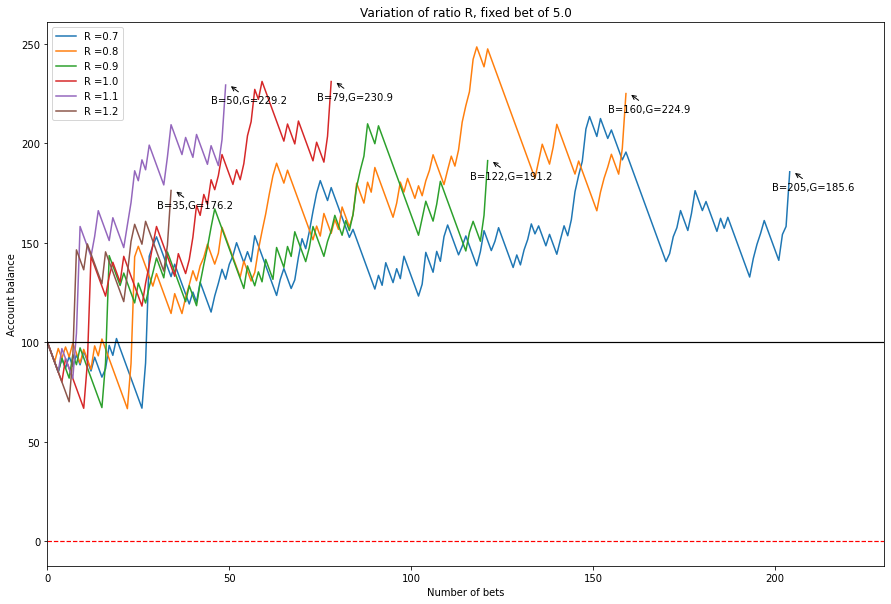

In [112]:
# Influence of the decision ratio R (One considers all the matches in the Test dataset)
# Fixed bets are considered

# Initial balance: 100
# Fixed bet: 5
# Values considered for R in variable param_var

param_var = [0.7, 0.8, 0.9, 1, 1.1, 1.2] # Variation of alpha
fixed_bet = 5
initial_bankroll = 100

fig = plt.figure(figsize = (15, 10))
ax = fig.add_subplot(111) 

for i in param_var:
    #betting_workflow_R_Fixed(R, fixed, initial_bet, prob_computed, odds, winning, match_id)
    gain, match = betting_workflow_R_Fixed(i , fixed_bet, initial_bankroll, df_bet['Match_Prediction_proba'], df_bet['Best_odd'], df_bet['Winning_bet'], df_bet.index)
    ax.plot(range(0,len(gain)), gain, label="R ={:.1f}".format(i)) 
    ax.annotate("B={0:.0f},G={1:.1f}".format(len(gain),gain[-1]), xy=(len(gain), gain[-1]), xytext=(20, -20), textcoords='offset points', ha='center', va='bottom', arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
ax.set_xticks(range(0,250, 50))
plt.xlim((0, 230))
ax.axhline(y=0  , xmin=0, xmax=1, color ='red', linestyle='--', linewidth=1.2)
ax.axhline(y=100, xmin=0, xmax=1, color ='black', linestyle='-', linewidth=1.2)
ax.set_title('Variation of ratio R, fixed bet of {:.1f}'.format(fixed_bet))
ax.set_ylabel('Account balance')
ax.set_xlabel('Number of bets')
ax.legend(loc='upper left')

# B is the number of bets considered / G is the final gain
# Conclusion and remarks
# No clear tendency (curves seem to stopp increasing). Optimum around 1.1

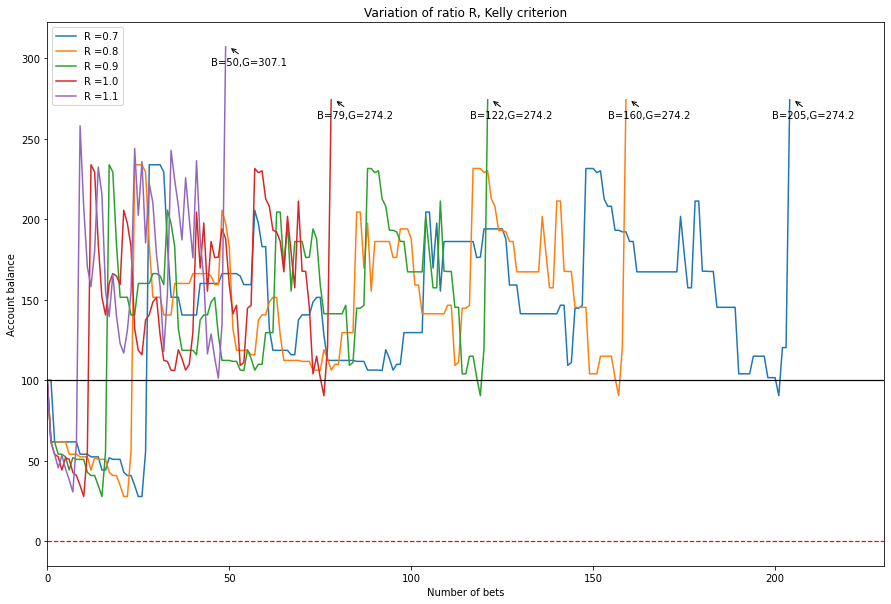

In [113]:
# Influence of the decision ratio R (One considers all the matches in the Test dataset)
# Kelly criterion is considered

# Initial balance: 100
# Kelly criterion
# Values considered for R in variable param_var

param_var = [0.7, 0.8, 0.9, 1, 1.1] # variation of R
beta = 1        # % of the Kelly criterion considered
limit = 1 # One cannot bet above this bankroll proportion
initial_bankroll = 100
 
fig = plt.figure(figsize = (15, 10))
ax = fig.add_subplot(111) 

for i in param_var:
    #betting_workflow_R_Kelly(R, beta, limit, initial_bet, prob_computed, odds, winning, match_id)
    gain, match = betting_workflow_R_Kelly(i , beta, limit, initial_bankroll, df_bet['Match_Prediction_proba'], df_bet['Best_odd'], df_bet['Winning_bet'], df_bet.index)
    ax.plot(range(0,len(gain)), gain, label="R ={:.1f}".format(i)) 
    ax.annotate("B={0:.0f},G={1:.1f}".format(len(gain),gain[-1]), xy=(len(gain), gain[-1]), xytext=(20, -20), textcoords='offset points', ha='center', va='bottom', arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
ax.set_xticks(range(0,260,50))
plt.xlim((0, 230))
ax.axhline(y=0  , xmin=0, xmax=1, color ='red', linestyle='--', linewidth=1.2)
ax.axhline(y=100, xmin=0, xmax=1, color ='black', linestyle='-', linewidth=1.2)
ax.set_title('Variation of ratio R, Kelly criterion')
ax.set_ylabel('Account balance')
ax.set_xlabel('Number of bets')
ax.legend(loc='upper left')

# B is the number of bets considered / G is the final gain
# Conclusion and remarks
# for R<1, the same shape and final result. It is expected as the kelly criterion is 0 if R<1 (it cannot be negative)
# Results are not satisfying as the bankroll is always decreasing

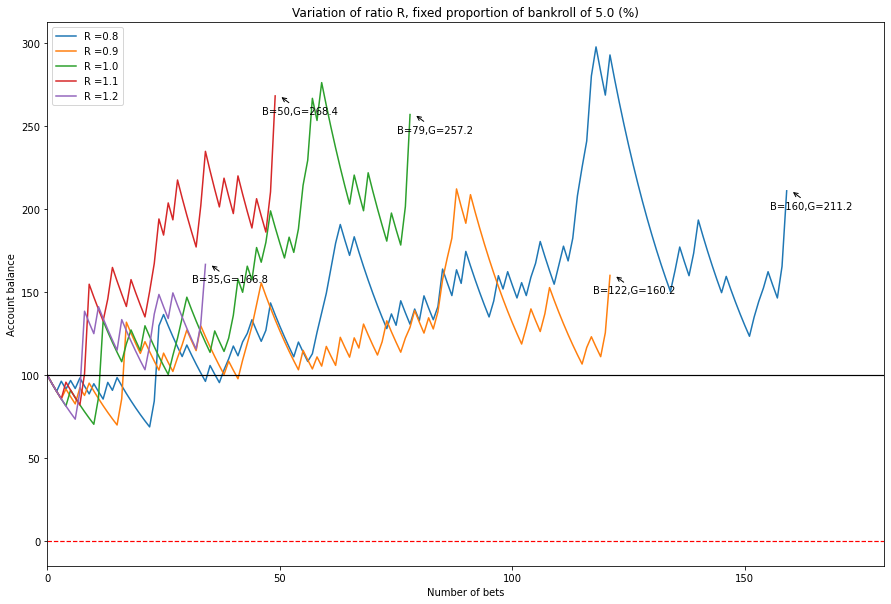

In [114]:
# Influence of the decision ratio R (One considers all the matches in the Test dataset)
# Fixed proportion of the bankroll is considered for betting

# Initial balance: 100
# Fixed proportion of the bankroll
# Values considered for R in variable param_var

param_var = [0.8, 0.9, 1, 1.1, 1.2] # variation of R
fixed_prop = 0.05        # Fixed % of the bankroll for betting
initial_bankroll = 100
 
fig = plt.figure(figsize = (15, 10))
ax = fig.add_subplot(111) 

for i in param_var:
    # betting_workflow_R_Fixed_Proportion(R, fixed_prop, initial_bet, prob_computed, odds, winning, match_id)
    gain, match = betting_workflow_R_Fixed_Proportion(i , fixed_prop, initial_bankroll, df_bet['Match_Prediction_proba'], df_bet['Best_odd'], df_bet['Winning_bet'], df_bet.index)
    ax.plot(range(0,len(gain)), gain, label="R ={:.1f}".format(i)) 
    ax.annotate("B={0:.0f},G={1:.1f}".format(len(gain),gain[-1]), xy=(len(gain), gain[-1]), xytext=(20, -20), textcoords='offset points', ha='center', va='bottom', arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
ax.set_xticks(range(0,210,50))
plt.xlim((0, 180))
ax.axhline(y=0  , xmin=0, xmax=1, color ='red', linestyle='--', linewidth=1.2)
ax.axhline(y=100, xmin=0, xmax=1, color ='black', linestyle='-', linewidth=1.2)
ax.set_title('Variation of ratio R, fixed proportion of bankroll of {:.1f} (%)'.format(fixed_prop*100))
ax.set_ylabel('Account balance')
ax.set_xlabel('Number of bets')
ax.legend(loc='upper left')

# B is the number of bets considered / G is the final gain
# Conclusion and remarks
# Seems more efficient than a fixed bet but with higher variations
# Optimum around 1.1

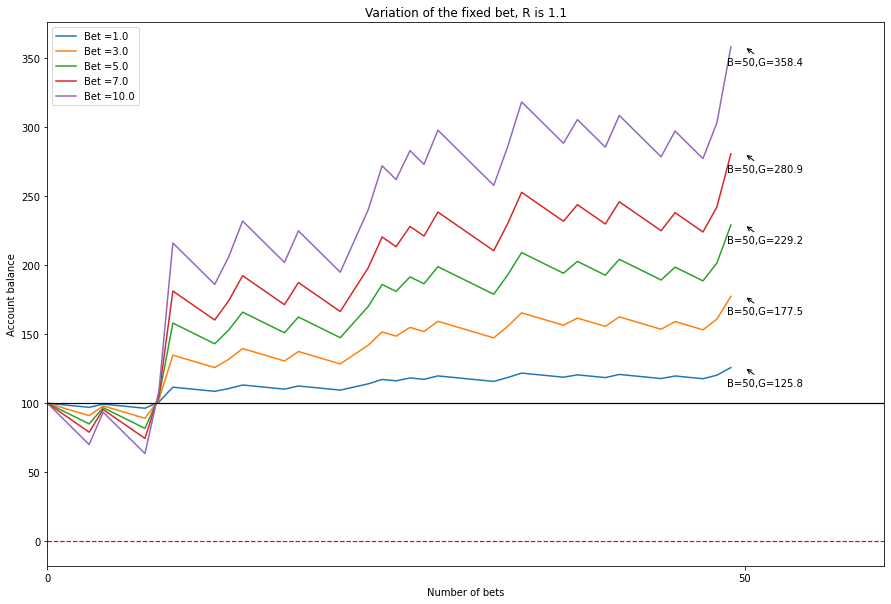

In [115]:
# Influence of the fixed bet value (One considers all the matches in the Test dataset)
# Optimum alpha value is considered

# Initial balance: 100
# Optimum R = 1.1
# Values considered for fixed bet in variable param_var

param_var = [1, 3, 5, 7, 10] # variation of the fixed bet amount
R = 1.1
initial_bankroll = 100

fig = plt.figure(figsize = (15, 10))
ax = fig.add_subplot(111) 

for i in param_var:
    #betting_workflow_R_Fixed(R, fixed, initial_bet, prob_computed, odds, winning, match_id)
    gain, match = betting_workflow_R_Fixed(R , i, initial_bankroll, df_bet['Match_Prediction_proba'], df_bet['Best_odd'], df_bet['Winning_bet'], df_bet.index)
    ax.plot(range(0,len(gain)), gain, label="Bet ={:.1f}".format(i)) 
    ax.annotate("B={0:.0f},G={1:.1f}".format(len(gain),gain[-1]), xy=(len(gain), gain[-1]), xytext=(20, -20), textcoords='offset points', ha='center', va='bottom', arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
ax.set_xticks(range(0,200,50))
plt.xlim((0, 60))
ax.axhline(y=0  , xmin=0, xmax=1, color ='red', linestyle='--', linewidth=1.2)
ax.axhline(y=100, xmin=0, xmax=1, color ='black', linestyle='-', linewidth=1.2)
ax.set_title('Variation of the fixed bet, R is {:.1f}'.format(R))
ax.set_ylabel('Account balance')
ax.set_xlabel('Number of bets')
ax.legend(loc='upper left')

# B is the number of bets considered / G is the final gain
# Conclusion and remarks
# The curve shape is always the same. The highest fixed bet amount ends up with 
# the highest profit (end the biggest loss)

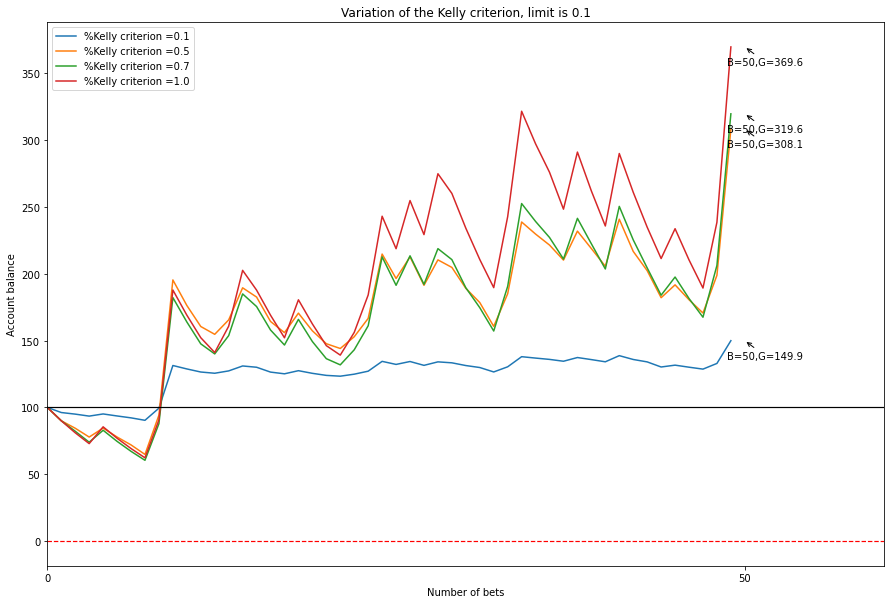

In [116]:
# Influence of the Kelly criterion (One considers all the matches in the Test dataset)

# Initial balance: 100
# Optimum R = 1.1
# The % of the Kelly criterion considered varies, moreover, the Kelly criterion is limited and cannot be more that the "limit" 
# parameter. Here 10%

param_var = [0.1, 0.5, 0.7, 1] # variation of beta
R = 1.1
limit = 0.1 # One cannot bet above this bankroll proportion
initial_bankroll = 100
 
fig = plt.figure(figsize = (15, 10))
ax = fig.add_subplot(111) 

for i in param_var:
    #betting_workflow_R_Kelly(R, beta, limit, initial_bet, prob_computed, odds, winning, match_id)
    gain, match = betting_workflow_R_Kelly(R , i, limit, initial_bankroll, df_bet['Match_Prediction_proba'], df_bet['Best_odd'], df_bet['Winning_bet'], df_bet.index)
    ax.plot(range(0,len(gain)), gain, label="%Kelly criterion ={:.1f}".format(i)) 
    ax.annotate("B={0:.0f},G={1:.1f}".format(len(gain),gain[-1]), xy=(len(gain), gain[-1]), xytext=(20, -20), textcoords='offset points', ha='center', va='bottom', arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
ax.set_xticks(range(0,200,50))
plt.xlim((0, 60))
ax.axhline(y=0  , xmin=0, xmax=1, color ='red', linestyle='--', linewidth=1.2)
ax.axhline(y=100, xmin=0, xmax=1, color ='black', linestyle='-', linewidth=1.2)
ax.set_title('Variation of the Kelly criterion, limit is {:.1f}'.format(limit))
ax.set_ylabel('Account balance')
ax.set_xlabel('Number of bets')
ax.legend(loc='upper left')

# B is the number of bets considered / G is the final gain
# Conclusion and remarks
# The problem with the Kelly criterion is the high values that can be computed leading to 
# potential high losses. We try two way of limiting the Kelly criterion: 
# - By considering a fraction of it
# - by limiting its maximum value
# Limiting the max of the Kelly criterion via the parameter "limit" gives very good results. The increasing tendency is kept

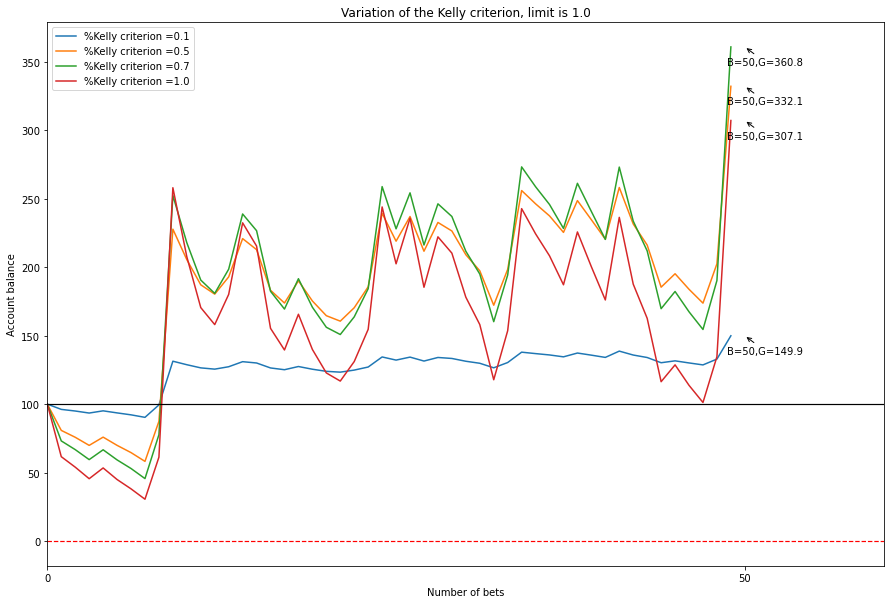

In [117]:
# Influence of the Kelly criterion (One considers all the matches in the Test dataset)

# Initial balance: 100
# Optimum R = 1.1
# The % of the Kelly criterion considered varies, moreover

param_var = [0.1, 0.5, 0.7, 1] # variation of beta
R = 1.1
limit = 1 # One cannot bet above this bankroll proportion
initial_bankroll = 100
 
fig = plt.figure(figsize = (15, 10))
ax = fig.add_subplot(111) 

for i in param_var:
    #betting_workflow_R_Kelly(R, beta, limit, initial_bet, prob_computed, odds, winning, match_id)
    gain, match = betting_workflow_R_Kelly(R , i, limit, initial_bankroll, df_bet['Match_Prediction_proba'], df_bet['Best_odd'], df_bet['Winning_bet'], df_bet.index)
    ax.plot(range(0,len(gain)), gain, label="%Kelly criterion ={:.1f}".format(i)) 
    ax.annotate("B={0:.0f},G={1:.1f}".format(len(gain),gain[-1]), xy=(len(gain), gain[-1]), xytext=(20, -20), textcoords='offset points', ha='center', va='bottom', arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
ax.set_xticks(range(0,200,50))
plt.xlim((0, 60))
ax.axhline(y=0  , xmin=0, xmax=1, color ='red', linestyle='--', linewidth=1.2)
ax.axhline(y=100, xmin=0, xmax=1, color ='black', linestyle='-', linewidth=1.2)
ax.set_title('Variation of the Kelly criterion, limit is {:.1f}'.format(limit))
ax.set_ylabel('Account balance')
ax.set_xlabel('Number of bets')
ax.legend(loc='upper left')

# B is the number of bets considered / G is the final gain
# Conclusion and remarks
# As it has been seen above, the problem with the Kelly criterion is the high values that can be computed leading to 
# potential hugh losses. We try two way of limiting the Kelly criterion: 
# - By considering a fraction of it
# - by limiting its maximum value
# Limiting the Kelly criterion without considering a max limit is worse in the sense we lost the increasing tendency

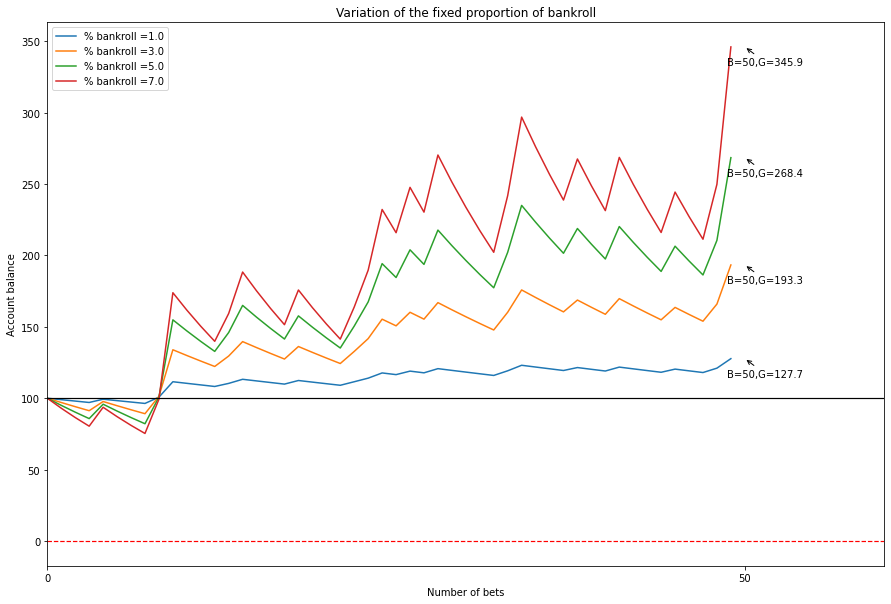

In [118]:
# Influence of the fixed prop bet (One considers all the matches in the Test dataset)

# Initial balance: 100
# Optimum R = 1.1

param_var = [0.01, 0.03, 0.05, 0.07]
initial_bankroll = 100
R = 1.1
fig = plt.figure(figsize = (15, 10))
ax = fig.add_subplot(111) 

for i in param_var:
    # betting_workflow_R_Fixed_Proportion(R, fixed_prop, initial_bet, prob_computed, odds, winning, match_id)
    gain, match = betting_workflow_R_Fixed_Proportion(R , i, initial_bankroll, df_bet['Match_Prediction_proba'], df_bet['Best_odd'], df_bet['Winning_bet'], df_bet.index)
    ax.plot(range(0,len(gain)), gain, label="% bankroll ={:.1f}".format(i*100)) 
    ax.annotate("B={0:.0f},G={1:.1f}".format(len(gain),gain[-1]), xy=(len(gain), gain[-1]), xytext=(20, -20), textcoords='offset points', ha='center', va='bottom', arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
ax.set_xticks(range(0,200,50))
plt.xlim((0, 60))
ax.axhline(y=0  , xmin=0, xmax=1, color ='red', linestyle='--', linewidth=1.2)
ax.axhline(y=100, xmin=0, xmax=1, color ='black', linestyle='-', linewidth=1.2)
ax.set_title('Variation of the fixed proportion of bankroll')
ax.set_ylabel('Account balance')
ax.set_xlabel('Number of bets')
ax.legend(loc='upper left')

# B is the number of bets considered / G is the final gain
# Conclusion and remarks
# The curve shape is always the same
# The bet considering the highest fixed proportion of the bankroll ends up with the highest profit
# Increasing tendency is kept and the strategy gives good results

In [133]:
print("G={:.1f}".format(1.1))

G=1.1


### 2.1 Influence of the probability threshold

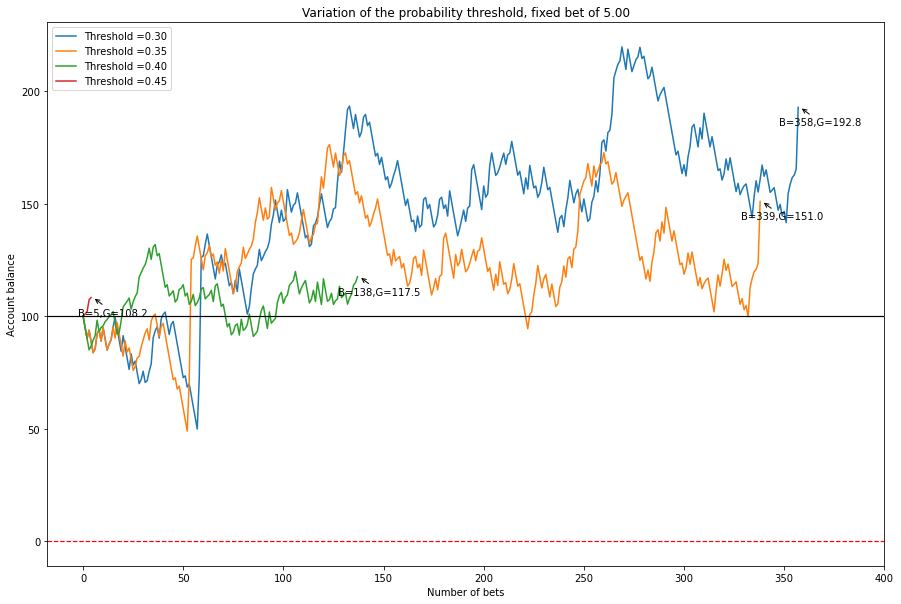

In [119]:
# Influence of the threshold (One considers all the matches in the Test dataset)
# Fixed bets are considered

# Initial balance: 100
# Fixed bet: 5
# Values considered for the threshold in variable param_var

param_var = [0.3,0.35, 0.4, 0.45] # variation of the threshold
fixed_bet = 5
initial_bankroll = 100

fig = plt.figure(figsize = (15, 10))
ax = fig.add_subplot(111) 

for i in param_var:
    #betting_workflow_Threshold_Fixed(threshold, fixed, initial_bet, prob_computed, odds, winning, match_id): 
    gain, match = betting_workflow_Threshold_Fixed(i , fixed_bet, initial_bankroll, df_bet['Match_Prediction_proba'], df_bet['Best_odd'], df_bet['Winning_bet'], df_bet.index)
    ax.plot(range(0,len(gain)), gain, label="Threshold ={:.2f}".format(i)) 
    ax.annotate("B={0:.0f},G={1:.1f}".format(len(gain),gain[-1]), xy=(len(gain), gain[-1]), xytext=(20, -20), textcoords='offset points', ha='center', va='bottom', arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
ax.set_xticks(range(0,450,50))
ax.axhline(y=0  , xmin=0, xmax=1, color ='red', linestyle='--', linewidth=1.2)
ax.axhline(y=100, xmin=0, xmax=1, color ='black', linestyle='-', linewidth=1.2)
ax.set_title('Variation of the probability threshold, fixed bet of {:.2f}'.format(fixed_bet))
ax.set_ylabel('Account balance')
ax.set_xlabel('Number of bets')
ax.legend(loc='upper left')

# B is the number of bets considered / G is the final gain
# Conclusion and remarks
# High threshold doesn't necessarily give the best result. It reduces the number of bet and the accuracy of 
# the model is not good enough to secure the gain
# Only a high threshold leads to a secure benefit and only few games are considered.
# Under a threshold of 0.3, all available games in the dataset are considered for betting

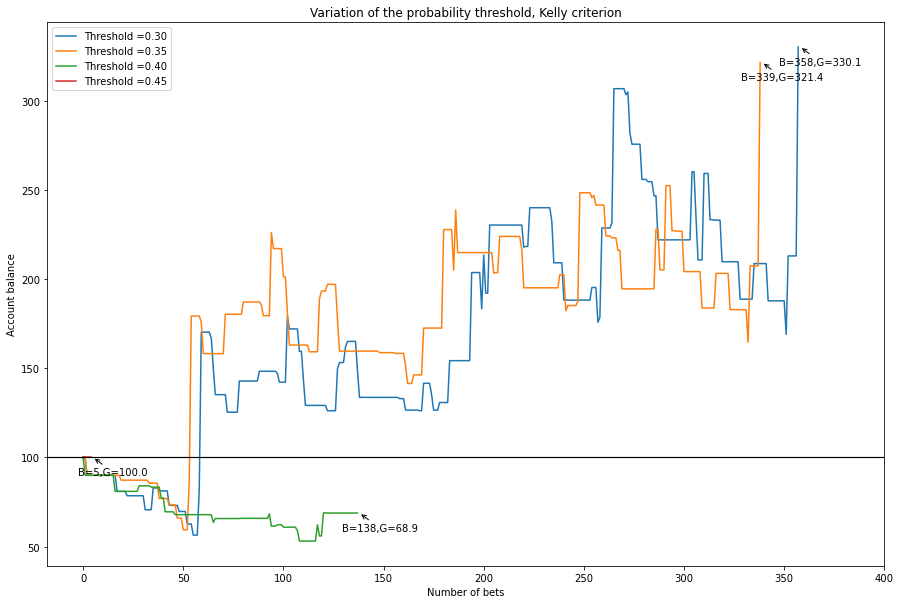

In [120]:
# Influence of the threshold (One considers all the matches in the Test dataset)
# Kelly criterion is considered

# Initial balance: 100
# Kelly criterion
# Values considered for the threshold in variable param_var

param_var = [0.3,0.35, 0.4, 0.45] # variation of the threshold
beta = 1 # % of the kelly criterion considered
limit = 0.1 # limits the Kelly criterion
initial_bankroll = 100

fig = plt.figure(figsize = (15, 10))
ax = fig.add_subplot(111) 

for i in param_var:
    #betting_workflow_Threshold_Kelly(threshold, beta, limit, initial_bet, prob_computed, odds, winning, match_id):
    gain, match = betting_workflow_Threshold_Kelly(i , beta, limit, initial_bankroll, df_bet['Match_Prediction_proba'], df_bet['Best_odd'], df_bet['Winning_bet'], df_bet.index)
    ax.plot(range(0,len(gain)), gain, label="Threshold ={:.2f}".format(i)) 
    ax.annotate("B={0:.0f},G={1:.1f}".format(len(gain),gain[-1]), xy=(len(gain), gain[-1]), xytext=(20, -20), textcoords='offset points', ha='center', va='bottom', arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
ax.set_xticks(range(0,450,50))
#ax.axhline(y=0  , xmin=0, xmax=1, color ='red', linestyle='--', linewidth=1.2)
ax.axhline(y=100, xmin=0, xmax=1, color ='black', linestyle='-', linewidth=1.2)
ax.set_title('Variation of the probability threshold, Kelly criterion')
ax.set_ylabel('Account balance')
ax.set_xlabel('Number of bets')
ax.legend(loc='upper left')

# B is the number of bets considered / G is the final gain
# Conclusion and remarks
# Good results in terms of benefits.
# The threshold doesn't give better results

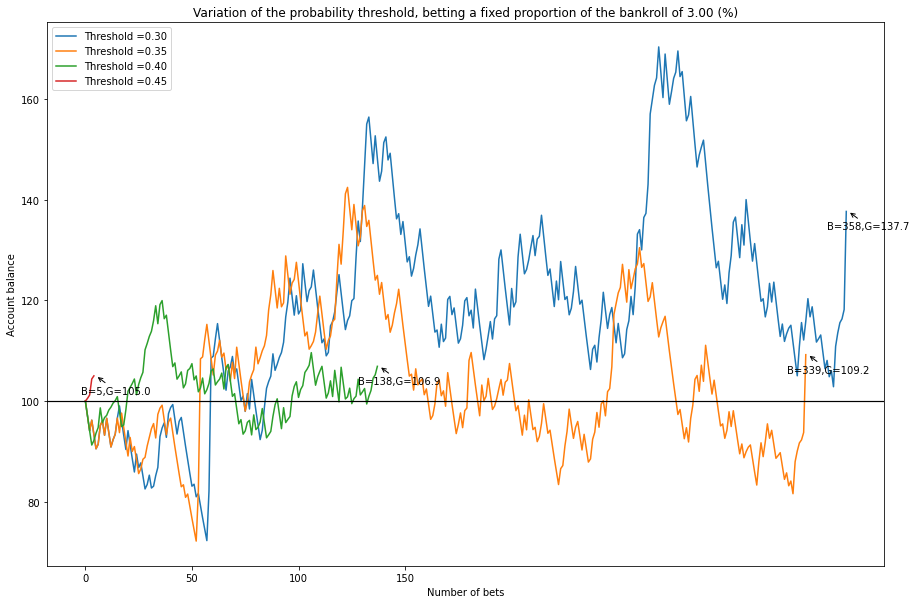

In [121]:
# Influence of the threshold (One considers all the matches in the Test dataset)
# Fixed proportion of the bankroll is considered for the bet

# Initial balance: 100
# Fixed proportion of the bankroll
# Values considered for the threshold in variable param_var

param_var = [0.3,0.35, 0.4, 0.45] # variation of the threshold
fixed_prop = 0.03
initial_bankroll = 100

fig = plt.figure(figsize = (15, 10))
ax = fig.add_subplot(111) 

for i in param_var:
    #betting_workflow_Threshold_Fixed_Proportion(threshold, fixed_prop, initial_bet, prob_computed, odds, winning, match_id):
    gain, match = betting_workflow_Threshold_Fixed_Proportion(i , fixed_prop, initial_bankroll, df_bet['Match_Prediction_proba'], df_bet['Best_odd'], df_bet['Winning_bet'], df_bet.index)
    ax.plot(range(0,len(gain)), gain, label="Threshold ={:.2f}".format(i)) 
    ax.annotate("B={0:.0f},G={1:.1f}".format(len(gain),gain[-1]), xy=(len(gain), gain[-1]), xytext=(20, -20), textcoords='offset points', ha='center', va='bottom', arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
ax.set_xticks(range(0,170,50))
#ax.axhline(y=0  , xmin=0, xmax=1, color ='red', linestyle='--', linewidth=1.2)
ax.axhline(y=100, xmin=0, xmax=1, color ='black', linestyle='-', linewidth=1.2)
ax.set_title('Variation of the probability threshold, betting a fixed proportion of the bankroll of {:.2f} (%)'.format(fixed_prop*100))
ax.set_ylabel('Account balance')
ax.set_xlabel('Number of bets')
ax.legend(loc='upper left')

# B is the number of bets considered / G is the final gain
# Conclusion and remarks
# Same conclusion as previously 
# No clear tendency of the curves

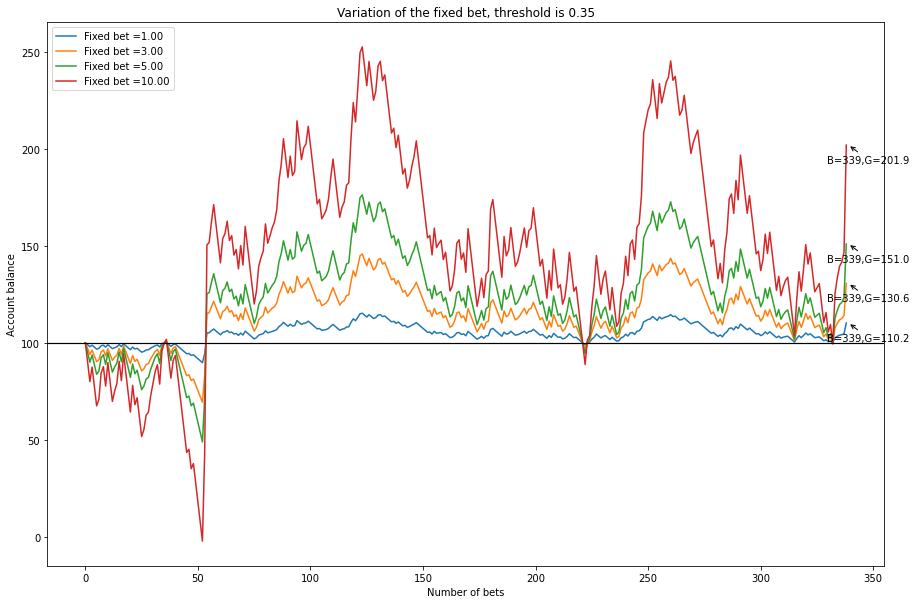

In [122]:
# Optimum threshold & fixed bet variation

# Initial balance: 100
# Fixed bet from 1 to 15
# Optimum Threshold = 0.35

param_var = [1, 3, 5, 10]
threshold =0.35
initial_bankroll = 100

fig = plt.figure(figsize = (15, 10))
ax = fig.add_subplot(111) 

for i in param_var:
    #betting_workflow_Threshold_Fixed(threshold, fixed, initial_bet, prob_computed, odds, winning, match_id): 
    gain, match = betting_workflow_Threshold_Fixed(threshold , i, initial_bankroll, df_bet['Match_Prediction_proba'], df_bet['Best_odd'], df_bet['Winning_bet'], df_bet.index)
    ax.plot(range(0,len(gain)), gain, label="Fixed bet ={:.2f}".format(i)) 
    ax.annotate("B={0:.0f},G={1:.1f}".format(len(gain),gain[-1]), xy=(len(gain), gain[-1]), xytext=(20, -20), textcoords='offset points', ha='center', va='bottom', arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
ax.set_xticks(range(0,400,50))
#ax.axhline(y=0  , xmin=0, xmax=1, color ='red', linestyle='--', linewidth=1.2)
ax.axhline(y=100, xmin=0, xmax=1, color ='black', linestyle='-', linewidth=1.2)
ax.set_title('Variation of the fixed bet, threshold is {:.2f}'.format(threshold))
ax.set_ylabel('Account balance')
ax.set_xlabel('Number of bets')
ax.legend(loc='upper left')

# B is the number of bets considered / G is the final gain
# The curve shape is always the same same conclusion as per the R ratio.

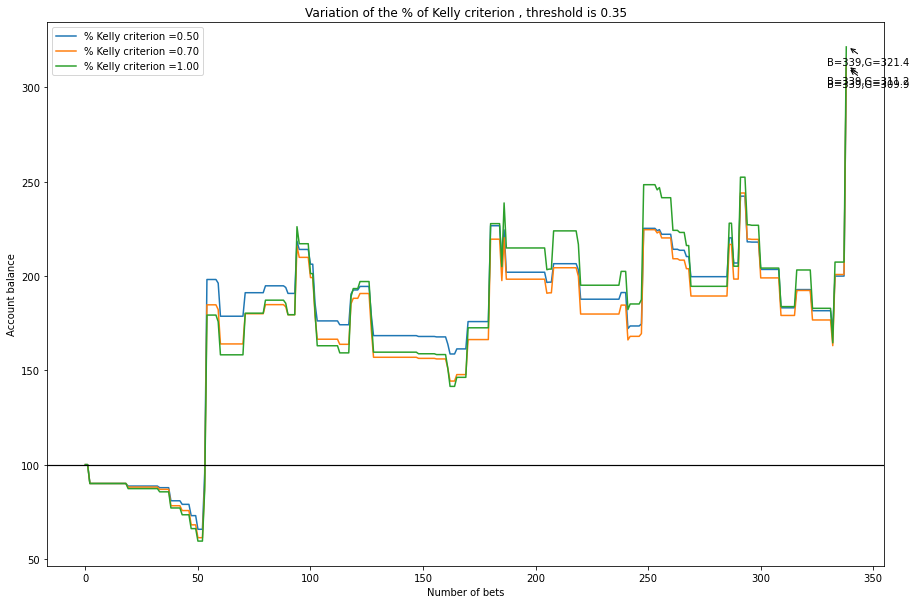

In [123]:
# Opt threshold & Kelly criterion: Variation of beta considering a limit of 10%

# Initial balance: 100
# f varies
# Optimum Threshold = 0.35

param_var = [0.5, 0.7, 1] # variation of beta
limit = 0.1 # One cannot bet above this bankroll proportion
initial_bankroll = 100
threshold = 0.35

fig = plt.figure(figsize = (15, 10))
ax = fig.add_subplot(111) 

for i in param_var:
    #betting_workflow_Threshold_Kelly(threshold, beta, limit, initial_bet, prob_computed, odds, winning, match_id):
    gain, match = betting_workflow_Threshold_Kelly(threshold , i, limit, initial_bankroll, df_bet['Match_Prediction_proba'], df_bet['Best_odd'], df_bet['Winning_bet'], df_bet.index)
    ax.plot(range(0,len(gain)), gain, label="% Kelly criterion ={:.2f}".format(i)) 
    ax.annotate("B={0:.0f},G={1:.1f}".format(len(gain),gain[-1]), xy=(len(gain), gain[-1]), xytext=(20, -20), textcoords='offset points', ha='center', va='bottom', arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
ax.set_xticks(range(0,400,50))
#ax.axhline(y=0  , xmin=0, xmax=1, color ='red', linestyle='--', linewidth=1.2)
ax.axhline(y=100, xmin=0, xmax=1, color ='black', linestyle='-', linewidth=1.2)
ax.set_title('Variation of the % of Kelly criterion , threshold is {:.2f}'.format(threshold))
ax.set_ylabel('Account balance')
ax.set_xlabel('Number of bets')
ax.legend(loc='upper left')

# B is the number of bets considered / G is the final gain
# Same conclusion as per the R ratio

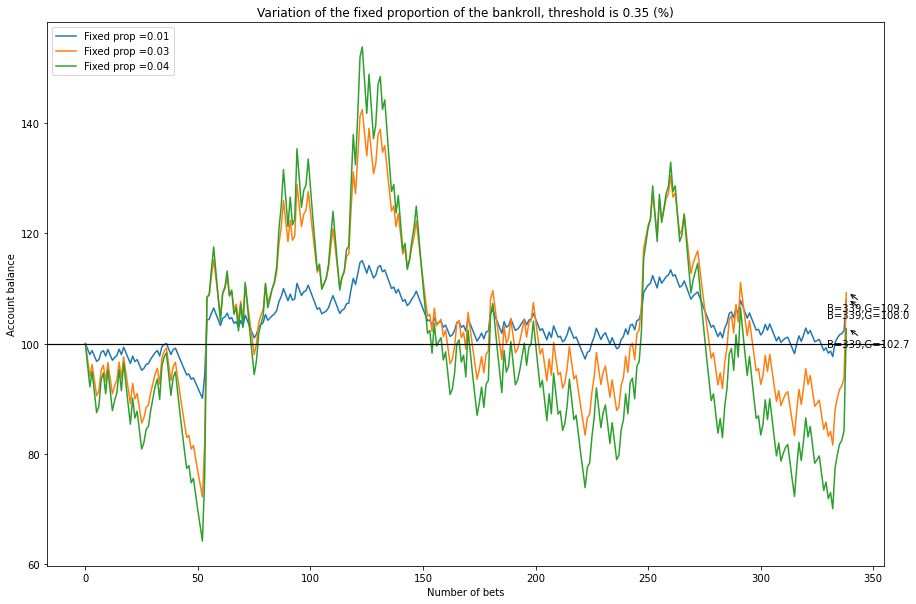

In [124]:
# Opt threshold & Var fixed prop bet

# Initial balance: 100
# Fixed proportion of the bankroll
# Values considered for the threshold in variable param_var
# Optimum  threshold of 0.35
param_var = [0.01, 0.03, 0.04]
initial_bankroll = 100
threshold = 0.35

fig = plt.figure(figsize = (15, 10))
ax = fig.add_subplot(111) 

for i in param_var:
    #betting_workflow_Threshold_Fixed_Proportion(threshold, fixed_prop, initial_bet, prob_computed, odds, winning, match_id):
    gain, match = betting_workflow_Threshold_Fixed_Proportion(threshold , i, initial_bankroll, df_bet['Match_Prediction_proba'], df_bet['Best_odd'], df_bet['Winning_bet'], df_bet.index)
    ax.plot(range(0,len(gain)), gain, label="Fixed prop ={:.2f}".format(i)) 
    ax.annotate("B={0:.0f},G={1:.1f}".format(len(gain),gain[-1]), xy=(len(gain), gain[-1]), xytext=(20, -20), textcoords='offset points', ha='center', va='bottom', arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
ax.set_xticks(range(0,400,50))
#ax.axhline(y=0  , xmin=0, xmax=1, color ='red', linestyle='--', linewidth=1.2)
ax.axhline(y=100, xmin=0, xmax=1, color ='black', linestyle='-', linewidth=1.2)
ax.set_title('Variation of the fixed proportion of the bankroll, threshold is {:.2f} (%)'.format(threshold))
ax.set_ylabel('Account balance')
ax.set_xlabel('Number of bets')
ax.legend(loc='upper left')

# B is the number of bets considered / G is the final gain
# No clear tendency, higher variation for higher bets

In [125]:
# Conclusion:
# R opt = 1.1, this decision criterion gives the best results

# It is difficult to select an optimum Threshold. Hight threshold leeds to few bets and low benefits. 
# The lowest threshold give better results as a high number of games are selected and an optimized bet amount can be found.


# Fixed bets or fixed bankroll proportion seems to provide higher benefits. 
# The Kelly criterion is only interesting for our problem when limiting its value (beta parameter) and limiting its value to a maximum


## 3. Betting strategies without prediction models

### 3.1 "Sure Bets"

A "sure bet" is a bet that guarantees a gain. A lot of websites provide this service of finding such bets. 
The idea is to bet on all possible outcome checking if the winning bet will provide a gain higher that all the losing bets.
For a game: if $\sum{p(i)} = 1 $ where p(i) is the probability of a possible outcome, and o(i) the associated odd. When betting on all possible events "i" the amount $B \cdot p(i)$ the total bet is $ B \cdot \sum{p(i)} = B $ 
If $j$ is the outcome of the match, we win $B \cdot p(j) \cdot o(j) = B$. Thus in this theoretical exemple we never lose (and never win) money.

For every bookmakers one has: $p(A)+p(D)+p(H) = 1 + \epsilon$, with $\epsilon > 0$ it is always strictly above 1.
$\epsilon$ is often called the bookmaker margin. 

Considering the previous approach we are sure to lose money because of this margin, by betting $ B\cdot p(i)$  on all possible outcomes (B in total) we win an amount strictly inferior to B.

Here the idea is to find matches where the following consition is found:
$$\frac{1}{\max_k{o(A)}} + \frac{1}{\max_k{o(D)}}  + \frac{1}{\max_k{o(H)}}  < 1 $$

where $o(A)$, $o(D)$ and $o(H)$ are respectively the odd associated to the event A, D, and H previously introduced.
The maximum is made over all bookmakers.

In [ ]:
# Exemple of Bookmaker margins
def margin(df):  
    bookmaker_list = ['B365', 'LB', 'PS', 'WH', 'VC', 'PSC']
    output = pd.DataFrame(columns= bookmaker_list)
    for i in range(len(df.index)):
        margin = [] 
        for j in bookmaker_list: # Check for sure bet
            margin.append(1/df.iloc[i, df.columns.get_loc(j+'A')]+1/df.iloc[i, df.columns.get_loc(j+'D')]+1/df.iloc[i, df.columns.get_loc(j+'H')]-1)
        to_append = pd.Series(margin, index = output.columns)
        output = output.append(to_append, ignore_index=True)
    return output

d = margin(df_bet)
d.head(5)

In [ ]:
def sure_bet(fixed, initial_bet, df):  
    gain = []
    match = []
    gain.append(initial_bet)
    
    bookmaker_list = ['B365', 'LB', 'PS', 'WH', 'VC', 'PSC']
    
    for i in range(len(df.index)):
        
        A = [] # odds for event A
        H = [] # odds for event H
        D = [] # odds for event D
        for j in bookmaker_list: # Check for sure bet
            A.append(df.iloc[i, df.columns.get_loc(j+'A')])
            H.append(df.iloc[i, df.columns.get_loc(j+'D')])
            D.append(df.iloc[i, df.columns.get_loc(j+'H')])
        
        if ((1/np.max(A) + 1/np.max(D) + 1/np.max(H))<1): # Check if one has a "sure bet"
            if (df['FTR'].iloc[i] =='A'):
                g = gain[-1] + fixed*(np.max(A)-1) 
            elif (df['FTR'].iloc[i] =='H'):
                g = gain[-1] + fixed*(np.max(H)-1) 
            else:
                g = gain[-1] + fixed*(np.max(D)-1) 
            gain.append(g)    
            match.append(df.index[i])
    return gain , match 


In [ ]:
param_var = [1, 10, 50, 100]
initial_bankroll = 100

fig = plt.figure(figsize = (15, 10))
ax = fig.add_subplot(111) 

for i in param_var:
    #sure_bet(fixed, initial_bet, df): 
    gain, match = sure_bet(i, initial_bankroll, df_bet)
    ax.plot(range(0,len(gain)), gain, label="Fixed bet ={:.2f}".format(i)) 
    ax.annotate("Bets={0:.1f},Sold={1:.1f}".format(len(gain),gain[-1]), xy=(len(gain), gain[-1]), xytext=(20, -20), textcoords='offset points', ha='center', va='bottom', arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
ax.set_xticks(range(0,300,50))
ax.axhline(y=100, xmin=0, xmax=1, color ='black', linestyle='-', linewidth=1.2)
ax.set_title('Variation of the fixed bet')
ax.set_ylabel('Account balance')
ax.set_xlabel('Number of bets')
ax.legend(loc='upper left')
# 202 Sure bets have been found for all 4 seasons. By definition the curve never decreases, 
# the highest bets give the highest gain

### 3.2 Bookmakers mistakes

In [ ]:
# Here we only bet on the bookmaker prediction (the minimum odd) 
# And when the difference between:
# the mean of the odds for this predicted event 
# maximum odd of this predicted event (max(min())) is high enough

In [ ]:
def book_bet(fixed, threshold, initial_bet, df):  
    gain = []
    match = []
    gain.append(initial_bet)
    
    bookmaker_list = ['B365', 'LB', 'PS', 'WH', 'VC', 'PSC']
    
    for i in range(len(df.index)):
        Result = []
        O = [] # odds of the predicted event
        for j in bookmaker_list:
            Result.append(df.iloc[i, df.columns.get_loc(j+'R')])
            O.append(df.iloc[i, df.columns.get_loc(j+Result[-1])])
        if all(ind == Result[0] for ind in Result): # We bet only if all the bookmakers predict the same result
            if (np.max(O)-np.mean(O) > threshold): 
                if (df['FTR'].iloc[i] == Result[-1]):
                    g = gain[-1] + fixed*(np.max(O)-1) 
                else:
                    g = gain[-1] - fixed
                gain.append(g)    
                match.append(df.index[i])
    return gain , match 

In [ ]:
param_var = [0, 0.05, 0.1, 0.15]
initial_bankroll = 100
fixed = 2
fig = plt.figure(figsize = (15, 10))
ax = fig.add_subplot(111) 

for i in param_var:
    # book_bet(fixed, threshold, initial_bet, df): 
    gain, match = book_bet(fixed, i, initial_bankroll, df_bookmakers)
    ax.plot(range(0,len(gain)), gain, label="Threshold ={:.2f}".format(i)) 
    ax.annotate("Bets={0:.1f},Sold={1:.1f}".format(len(gain),gain[-1]), xy=(len(gain), gain[-1]), xytext=(20, -20), textcoords='offset points', ha='center', va='bottom', arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
ax.set_xticks(range(0,1400,100))
ax.axhline(y=100, xmin=0, xmax=1, color ='black', linestyle='-', linewidth=1.2)
ax.set_title('Variation of the threshold, fixed bet is {:.2f} (%)'.format(fixed))
ax.set_ylabel('Account balance')
ax.set_xlabel('Number of bets')
ax.legend(loc='upper left')
# We spend 4 seasons on betting a fixed bet on the minimum odd and on the best offer, does not give satisfying results:
# no clear tendency and often no gain

# Conclusion

In [ ]:
# CSV save
df_bet.to_csv('df_betting_strategy.csv')